# Detección de Intrusiones y Análisis de Anomalías en Tráfico de Red mediante Técnicas Estadísticas

**Universidad de La Habana, MATCOM**  
**Curso:** Estadística 2025-2026  
**Proyecto Final:** Análisis Estadístico Aplicado a Seguridad Informática

---

## 1. Introducción

### 1.1 Contexto y Motivación

La seguridad informática es un pilar fundamental de la infraestructura tecnológica moderna. Los Sistemas de Detección de Intrusiones (IDS) tradicionales, basados en firmas conocidas, presentan limitaciones significativas frente a ataques emergentes (zero-day attacks). 

Este proyecto propone un **enfoque complementario basado en análisis estadístico del comportamiento del tráfico de red**, permitiendo identificar patrones anómalos sin depender exclusivamente de firmas catalogadas previamente. Esta aproximación resulta especialmente relevante en entornos dinámicos donde los ataques evolucionan constantemente.


### 1.2 Dataset: NSL-KDD

#### Descripción General

El dataset **NSL-KDD** fue desarrollado por investigadores del Canadian Institute for Cybersecurity (Universidad de New Brunswick) como versión corregida del benchmark KDD Cup 1999. Resuelve problemas críticos del dataset original (78% registros duplicados, sesgo de distribución) mediante eliminación de redundancias y balanceo mejorado de clases.

**Fuente:** [Kaggle - NSL-KDD](https://www.kaggle.com/datasets/hassan06/nslkdd) | Tavallaee et al. (2009)

**Dimensiones del dataset:**
- **Conjunto de entrenamiento (20%):** 25,192 observaciones
- **Conjunto de prueba:** 22,544 observaciones  
- **Variables:** 41 predictoras + 2 metadatos (`attack_type`, `difficulty_level`)


#### Categorías de Ataque

El dataset clasifica el tráfico de red en **5 categorías principales**:

| Categoría | Descripción | Ejemplos |
|-----------|-------------|----------|
| **Normal** | Tráfico legítimo | - |
| **DoS** | Denegación de servicio por sobrecarga | neptune, smurf, teardrop |
| **Probe** | Escaneo de vulnerabilidades | portsweep, nmap, satan |
| **R2L** | Acceso remoto no autorizado | guess_passwd, ftp_write |
| **U2R** | Escalada de privilegios | buffer_overflow, rootkit |


#### Estructura de Variables

Las 41 variables predictoras se agrupan en **4 categorías**:

- **Básicas (9):** Derivadas de cabeceras TCP/IP → *duration, protocol_type, service, flag, src_bytes, dst_bytes*
- **De contenido (13):** Información del payload → *num_failed_logins, root_shell, num_file_creations*
- **De tráfico temporal (9):** Ventanas de 2 segundos → *count, serror_rate, same_srv_rate*
- **Basadas en host (10):** Últimas 100 conexiones → *dst_host_count, dst_host_same_srv_rate*


### 1.3 Carga y Preparación Inicial

#### 1.3.1 Configuración del Entorno

In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn as sk
import scipy
import os
import statsmodels
import scikit_posthocs
# Configuración de visualizaciones
warnings.filterwarnings('ignore')
%matplotlib inline

# Estilo global para mantener consistencia en todas las visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Paleta de colores consistente para categorías de ataque
# Se utilizará en todas las visualizaciones del proyecto
attack_colors = {
    'Normal': '#2ecc71',    # Verde - Tráfico legítimo
    'DoS': '#e74c3c',       # Rojo - Ataques de denegación de servicio
    'Probe': '#f39c12',     # Naranja - Ataques de reconocimiento
    'R2L': '#9b59b6',       # Morado - Acceso remoto no autorizado
    'U2R': '#34495e'        # Gris oscuro - Escalada de privilegios
}

print("✅ Librerías importadas y configuración de visualización establecida. ")

✅ Librerías importadas y configuración de visualización establecida. 


#### 1.3.2 Carga de Archivos y Verificación de Estructura

In [3]:
# Definir los nombres de las columnas (43 columnas en total)
# Fuente: Documentación oficial NSL-KDD (Universidad de New Brunswick)
col_names = [
    # Variables básicas derivadas de cabeceras TCP/IP (9)
    "duration",           # Duración de la conexión en segundos
    "protocol_type",      # Protocolo: TCP, UDP, ICMP
    "service",            # Servicio de red destino (http, ftp, smtp, etc.)
    "flag",               # Estado de la conexión (SF, S0, REJ, etc.)
    "src_bytes",          # Bytes enviados desde origen a destino
    "dst_bytes",          # Bytes enviados desde destino a origen
    "land",               # 1 si origen y destino son iguales (ataque LAND)
    "wrong_fragment",     # Número de fragmentos incorrectos
    "urgent",             # Número de paquetes urgentes
    
    # Variables de contenido de la conexión (13)
    "hot",                # Número de indicadores "hot" (acceso a archivos críticos)
    "num_failed_logins",  # Número de intentos fallidos de login
    "logged_in",          # 1 si login exitoso
    "num_compromised",    # Número de condiciones "comprometidas"
    "root_shell",         # 1 si se obtuvo acceso root
    "su_attempted",       # 1 si comando "su root" fue intentado
    "num_root",           # Número de accesos root
    "num_file_creations", # Número de operaciones de creación de archivos
    "num_shells",         # Número de shells iniciados
    "num_access_files",   # Número de operaciones de acceso a archivos de control
    "num_outbound_cmds",  # Número de comandos FTP salientes (siempre 0 en dataset)
    "is_host_login",      # 1 si login es a host (no guest)
    "is_guest_login",     # 1 si login es de invitado
    
    # Variables de tráfico basadas en tiempo (ventana de 2 seg) (9)
    "count",              # Número de conexiones al mismo host en últimos 2 seg
    "srv_count",          # Número de conexiones al mismo servicio en últimos 2 seg
    "serror_rate",        # % de conexiones con errores SYN en count
    "srv_serror_rate",    # % de conexiones con errores SYN en srv_count
    "rerror_rate",        # % de conexiones con errores REJ en count
    "srv_rerror_rate",    # % de conexiones con errores REJ en srv_count
    "same_srv_rate",      # % de conexiones al mismo servicio en count
    "diff_srv_rate",      # % de conexiones a diferentes servicios en count
    "srv_diff_host_rate", # % de conexiones a diferentes hosts en srv_count
    
    # Variables de tráfico basadas en host (últimas 100 conexiones) (10)
    "dst_host_count",              # Conexiones al mismo host destino
    "dst_host_srv_count",          # Conexiones al mismo servicio en host destino
    "dst_host_same_srv_rate",      # % conexiones al mismo servicio
    "dst_host_diff_srv_rate",      # % conexiones a diferentes servicios
    "dst_host_same_src_port_rate", # % conexiones desde mismo puerto origen
    "dst_host_srv_diff_host_rate", # % conexiones desde diferentes hosts
    "dst_host_serror_rate",        # % errores SYN en dst_host_count
    "dst_host_srv_serror_rate",    # % errores SYN en dst_host_srv_count
    "dst_host_rerror_rate",        # % errores REJ en dst_host_count
    "dst_host_srv_rerror_rate",    # % errores REJ en dst_host_srv_count
    
    # Variables objetivo y metadatos (2)
    "attack_type",        # Etiqueta: tipo específico de ataque o "normal"
    "difficulty_level"    # Nivel de dificultad (0-21) asignado por los autores
]

# Cargar datasets
train_df = pd.read_csv('Data/KDDTrain+_20Percent.txt', names=col_names, header=None)
test_df = pd.read_csv('Data/KDDTest+.txt', names=col_names, header=None)

# Crear variable binaria para análisis de dos grupos (Normal vs. Ataque)
train_df['is_attack'] = (train_df['attack_type'] != 'normal').astype(int)
test_df['is_attack'] = (test_df['attack_type'] != 'normal').astype(int)

print(f"✅ Datos cargados:")
print(f"   Train: {train_df.shape[0]:,} × {train_df.shape[1]}")
print(f"   Test:  {test_df.shape[0]:,} × {test_df.shape[1]}")

display(train_df.head())

✅ Datos cargados:
   Train: 25,192 × 44
   Test:  22,544 × 44


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

#### 1.3.3 Mapeo de Categorías

In [5]:
# Diccionario oficial de mapeo de ataques específicos a categorías generales
# Fuente: Documentación oficial NSL-KDD (Canadian Institute for Cybersecurity)
attack_category_mapping = {
    # Tráfico Normal
    'normal': 'Normal',
    
    # DoS (Denial of Service) - Ataques de denegación de servicio
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe (Probing/Scanning) - Ataques de reconocimiento
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L (Remote to Local) - Acceso no autorizado desde máquina remota
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L',
    'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L',
    'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L' ,
    
    # U2R (User to Root) - Escalada de privilegios
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'rootkit': 'U2R', 'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R',
    'xterm': 'U2R'
}   

# Aplicar mapeo a ambos datasets
train_df['attack_category'] = train_df['attack_type'].map(attack_category_mapping)
test_df['attack_category'] = test_df['attack_type'].map(attack_category_mapping)

# Verificar que no hay valores sin mapear
unmapped_train = train_df['attack_category'].isna().sum()
unmapped_test = test_df['attack_category'].isna().sum()
print(f"   Valores sin mapear en train: {unmapped_train}")
print(f"   Valores sin mapear en test: {unmapped_test}")

# Crear orden categórico para visualizaciones consistentes
category_order = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
train_df['attack_category'] = pd.Categorical(
    train_df['attack_category'], 
    categories=category_order, 
    ordered=True
)
test_df['attack_category'] = pd.Categorical(
    test_df['attack_category'], 
    categories=category_order, 
    ordered=True
)

print("\n✅ Mapeo de categorías completado exitosamente")

   Valores sin mapear en train: 0
   Valores sin mapear en test: 0

✅ Mapeo de categorías completado exitosamente


---

## 2. Análisis Exploratorio de Datos (EDA)

---

### 2.1 Inspección General de la Estructura

Esta inspección verifica supuestos básicos necesarios para análisis estadístico: ausencia de valores faltantes, coherencia de rangos y correcta codificación de variables.

In [6]:
# ============================================================================
# 2.1.1 CLASIFICACIÓN DE VARIABLES
# ============================================================================

# Identificar tipos de variables
numeric_vars = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Excluir metadatos
metadata_vars = ['attack_type', 'attack_category', 'difficulty_level', 'is_attack']
numeric_vars = [v for v in numeric_vars if v not in metadata_vars]

# Separar binarias vs continuas
binary_vars = ['land', 'logged_in', 'is_host_login', 'is_guest_login']

continuous_vars = [v for v in numeric_vars if v not in binary_vars]

# Resumen
print(f"Variables continuas/discretas: {len(continuous_vars)}")
print(f"Variables binarias: {len(binary_vars)}")
print(f"Variables categóricas: {len(categorical_vars)}")

Variables continuas/discretas: 34
Variables binarias: 4
Variables categóricas: 5


#### 2.1.2 Verificación de Calidad de Datos

In [7]:
# VALORES FALTANTES
total_missing = train_df.isnull().sum().sum()
print(f"Valores faltantes: {total_missing}")

# Varianza 0
zero_variance_vars = [v for v in numeric_vars if train_df[v].var() == 0]
print(f"Variables con varianza 0: {zero_variance_vars}")

# VALIDACIÓN DE RANGOS

# Variables de tasa en [0,1]
rate_vars = [v for v in numeric_vars if 'rate' in v.lower()]
invalid_rates = sum((train_df[v] < 0).any() or (train_df[v] > 1).any() for v in rate_vars)
print(f"Variables de tasa fuera de rango: {invalid_rates}/{len(rate_vars)}")

# Variables binarias con solo {0,1}
invalid_binary = [v for v in binary_vars if not set(train_df[v].unique()).issubset({0, 1})]
print(f"Variables binarias inválidas: {len(invalid_binary)}/{len(binary_vars)}")

Valores faltantes: 0
Variables con varianza 0: ['num_outbound_cmds', 'is_host_login']
Variables de tasa fuera de rango: 0/15
Variables binarias inválidas: 0/4


### 2.2 Estadística Descriptiva por Tipo Funcional de Variable

Análisis univariado organizado según la naturaleza funcional de las variables en detección de intrusiones.


In [8]:
# Calcular estadísticos descriptivos
continuous_vars = [v for v in numeric_vars if v not in binary_vars]

descriptive_stats = pd.DataFrame({
    'Media': train_df[continuous_vars].mean(),
    'Mediana': train_df[continuous_vars].median(),
    'Desv_Std': train_df[continuous_vars].std(),
    'Min': train_df[continuous_vars].min(),
    'Q1': train_df[continuous_vars].quantile(0.25),
    'Q3': train_df[continuous_vars].quantile(0.75),
    'Max': train_df[continuous_vars].max(),
    'IQR': train_df[continuous_vars].quantile(0.75) - train_df[continuous_vars].quantile(0.25),
    'CV': (train_df[continuous_vars].std() / train_df[continuous_vars].mean()).replace([np.inf, -np.inf], np.nan),
    'Asimetría': train_df[continuous_vars].skew(),
    'Curtosis': train_df[continuous_vars].kurtosis()
}).round(4)


In [9]:
# Análisis de proporciones y varianza
binary_analysis = pd.DataFrame({
    'Prop_0': train_df[binary_vars].apply(lambda x: (x == 0).mean()),
    'Prop_1': train_df[binary_vars].apply(lambda x: (x == 1).mean()),
    'Count_0': train_df[binary_vars].apply(lambda x: (x == 0).sum()),
    'Count_1': train_df[binary_vars].apply(lambda x: (x == 1).sum()),
    'Varianza': train_df[binary_vars].var()
}).round(4)


#### 2.2.1 Variables Básicas (Cabeceras TCP/IP)

Información derivada directamente de las cabeceras de los paquetes de red.

**Variables numéricas:** duration, src_bytes, dst_bytes, wrong_fragment, urgent
**Variables categóricas:** protocol_type, service, flag
**Variables binarias:** land

In [10]:
# Variables básicas
basic_numeric = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent']
basic_categorical = ['protocol_type', 'service', 'flag']
basic_binary = ['land']

# Estadísticos de numéricas básicas
basic_stats = descriptive_stats.loc[basic_numeric]
print("Variables Básicas - Estadísticos Descriptivos:\n")
print(basic_stats.head().to_string())

basic_binary_analysis = binary_analysis.loc[basic_binary]
print("\nVariables Binarias Básicas:\n")
print(basic_binary_analysis.to_string())

Variables Básicas - Estadísticos Descriptivos:

                     Media  Mediana      Desv_Std  Min   Q1      Q3          Max     IQR        CV  Asimetría    Curtosis
duration          305.0541      0.0  2.686556e+03  0.0  0.0    0.00      42862.0    0.00    8.8068    11.5326    146.7010
src_bytes       24330.6282     44.0  2.410805e+06  0.0  0.0  279.00  381709090.0  279.00   99.0852   157.5585  24944.6143
dst_bytes        3491.8472      0.0  8.883072e+04  0.0  0.0  530.25    5151385.0  530.25   25.4395    54.7776   3130.1726
wrong_fragment      0.0237      0.0  2.602000e-01  0.0  0.0    0.00          3.0    0.00   10.9623    11.1844    124.3530
urgent              0.0000      0.0  6.300000e-03  0.0  0.0    0.00          1.0    0.00  158.7199   158.7199  25192.0000

Variables Binarias Básicas:

      Prop_0  Prop_1  Count_0  Count_1  Varianza
land  0.9999  0.0001    25190        2    0.0001


#### 2.2.2 Variables de Contenido (Payload)

Características extraídas del contenido de la conexión relacionadas con autenticación y acceso al sistema.

**Variables numéricas:** hot, num_failed_logins, num_compromised, num_root, num_file_creations, num_shells, num_access_files

**Variables binarias:** logged_in, root_shell, su_attempted, is_host_login, is_guest_login

In [11]:
# Variables de contenido
content_numeric = ['hot', 'num_failed_logins', 'num_compromised', 'num_root', 
                   'num_file_creations', 'num_access_files', 'num_shells']
content_binary = ['logged_in', 'is_guest_login']

# Estadísticos de numéricas de contenido
content_stats = descriptive_stats.loc[content_numeric]
print("\nVariables de Contenido - Estadísticos Descriptivos:\n")
print(content_stats.head().to_string())

# Análisis de binarias de contenido
content_binary_analysis = binary_analysis.loc[content_binary]
print("\nVariables Binarias de Contenido:\n")
print(content_binary_analysis.to_string())



Variables de Contenido - Estadísticos Descriptivos:

                     Media  Mediana  Desv_Std  Min   Q1   Q3    Max  IQR       CV  Asimetría   Curtosis
hot                 0.1980      0.0    2.1542  0.0  0.0  0.0   77.0  0.0  10.8777    13.5895   213.6980
num_failed_logins   0.0012      0.0    0.0454  0.0  0.0  0.0    4.0  0.0  38.1392    53.3126  3611.9223
num_compromised     0.2279      0.0   10.4174  0.0  0.0  0.0  884.0  0.0  45.7202    62.1911  4313.7758
num_root            0.2498      0.0   11.5008  0.0  0.0  0.0  975.0  0.0  46.0326    62.3211  4315.7675
num_file_creations  0.0147      0.0    0.5296  0.0  0.0  0.0   40.0  0.0  35.9616    52.1417  3158.2051

Variables Binarias de Contenido:

                Prop_0  Prop_1  Count_0  Count_1  Varianza
logged_in       0.6052  0.3948    15247     9945    0.2389
is_guest_login  0.9909  0.0091    24962      230    0.0090


#### 2.2.3 Variables de Tráfico Temporal (Ventana de 2 segundos)

Estadísticas calculadas sobre las últimas conexiones en una ventana temporal de 2 segundos.

**Variables numéricas:** count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate

In [12]:
# Variables de tráfico temporal
temporal_numeric = ['count', 'srv_count', 'serror_rate', 'srv_serror_rate', 
                    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
                    'diff_srv_rate', 'srv_diff_host_rate']

# Estadísticos de tráfico temporal
temporal_stats = descriptive_stats.loc[temporal_numeric]
print("\nVariables de Tráfico Temporal - Estadísticos Descriptivos:\n")
print(temporal_stats.head().to_string())


Variables de Tráfico Temporal - Estadísticos Descriptivos:

                   Media  Mediana  Desv_Std  Min   Q1     Q3    Max    IQR      CV  Asimetría  Curtosis
count            84.5912     14.0  114.6735  1.0  2.0  144.0  511.0  142.0  1.3556     1.5037    1.9780
srv_count        27.6988      8.0   72.4682  1.0  2.0   18.0  511.0   16.0  2.6163     4.7075   24.3967
serror_rate       0.2863      0.0    0.4473  0.0  0.0    1.0    1.0    1.0  1.5622     0.9526   -1.0744
srv_serror_rate   0.2838      0.0    0.4476  0.0  0.0    1.0    1.0    1.0  1.5774     0.9635   -1.0579
rerror_rate       0.1186      0.0    0.3187  0.0  0.0    0.0    1.0    0.0  2.6869     2.3464    3.5472


#### 2.2.4 Variables Basadas en Host (Últimas 100 conexiones)

Estadísticas calculadas sobre las últimas 100 conexiones al mismo host destino.

**Variables numéricas:** dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate

In [13]:
# Variables basadas en host
host_numeric = ['dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

# Estadísticos basadas en host
host_stats = descriptive_stats.loc[host_numeric]
print("\nVariables Basadas en Host - Estadísticos Descriptivos:\n")
print(host_stats.head().to_string())


Variables Basadas en Host - Estadísticos Descriptivos:

                                Media  Mediana  Desv_Std  Min     Q1      Q3    Max     IQR      CV  Asimetría  Curtosis
dst_host_count               182.5321   255.00   98.9939  0.0  84.00  255.00  255.0  171.00  0.5423    -0.8432   -1.0448
dst_host_srv_count           115.0630    61.00  110.6469  0.0  10.00  255.00  255.0  245.00  0.9616     0.2943   -1.7510
dst_host_same_srv_rate         0.5198     0.51    0.4489  0.0   0.05    1.00    1.0    0.95  0.8637    -0.0040   -1.8846
dst_host_diff_srv_rate         0.0825     0.03    0.1872  0.0   0.00    0.07    1.0    0.07  2.2679     3.6162   12.7275
dst_host_same_src_port_rate    0.1475     0.00    0.3084  0.0   0.00    0.06    1.0    0.06  2.0913     2.0985    2.8108


### 2.3 Visualización de Distribuciones por Tipo Funcional

#### 2.3.1 Variables Básicas (Cabeceras TCP/IP)

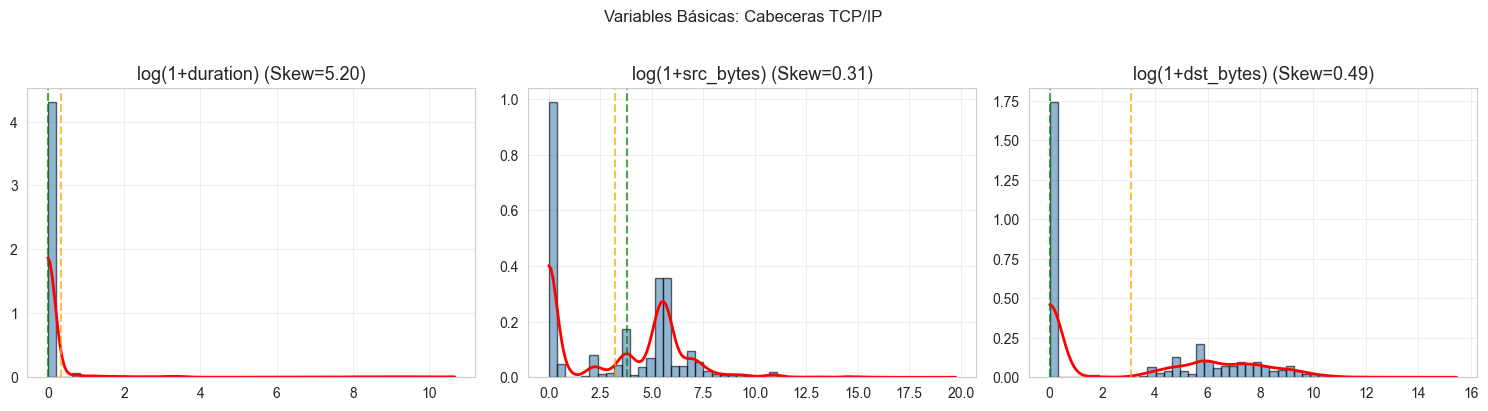

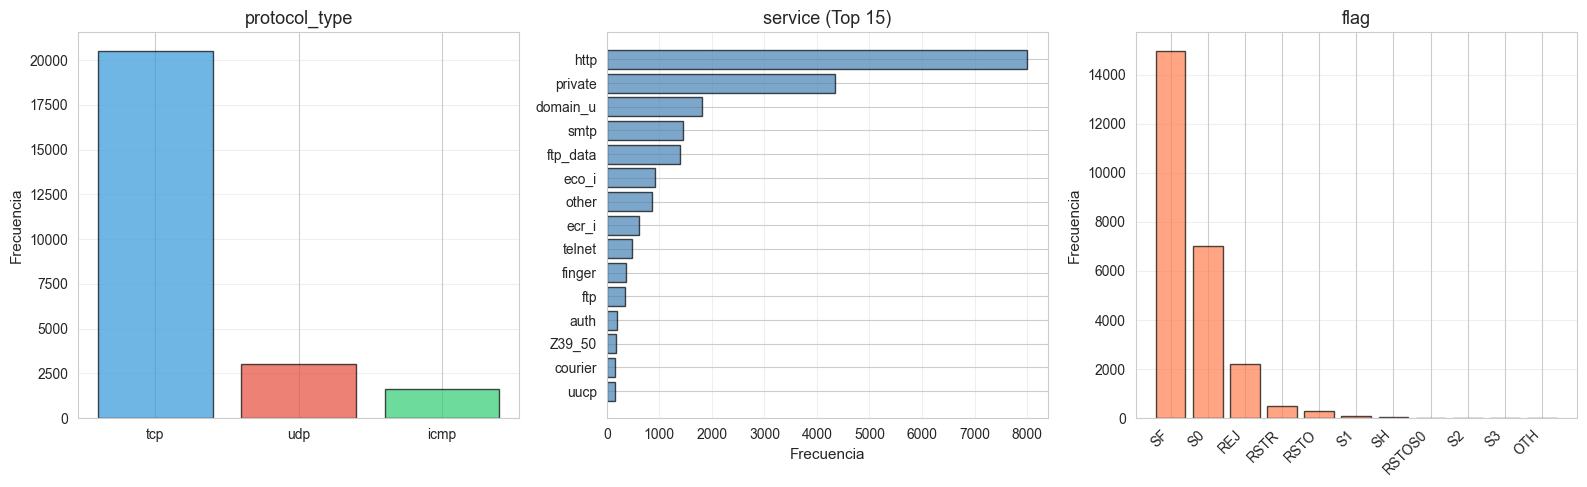

In [14]:
# Numéricas básicas - transformación log para variables con alta asimetría
basic_viz = ['duration', 'src_bytes', 'dst_bytes']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, var in zip(axes, basic_viz):
    data = np.log1p(train_df[var].dropna())
    
    ax.hist(data, bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    if data.std() > 0:
        kde = scipy.stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2)
    
    ax.axvline(data.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'log(1+{var}) (Skew={data.skew():.2f})')
    ax.grid(alpha=0.3)

plt.suptitle('Variables Básicas: Cabeceras TCP/IP', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Variables categóricas básicas
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# protocol_type
ax = axes[0]
protocol_counts = train_df['protocol_type'].value_counts()
ax.bar(protocol_counts.index, protocol_counts.values, 
       color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
ax.set_title('protocol_type')
ax.set_ylabel('Frecuencia')
ax.grid(alpha=0.3, axis='y')

# service (top 15)
ax = axes[1]
service_counts = train_df['service'].value_counts().head(15)
ax.barh(range(len(service_counts)), service_counts.values, 
        color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(service_counts)))
ax.set_yticklabels(service_counts.index)
ax.set_title('service (Top 15)')
ax.set_xlabel('Frecuencia')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# flag
ax = axes[2]
flag_counts = train_df['flag'].value_counts()
ax.bar(range(len(flag_counts)), flag_counts.values, 
       color='coral', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(flag_counts)))
ax.set_xticklabels(flag_counts.index, rotation=45, ha='right')
ax.set_title('flag')
ax.set_ylabel('Frecuencia')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### 2.3.2 Variables de Contenido (Payload)

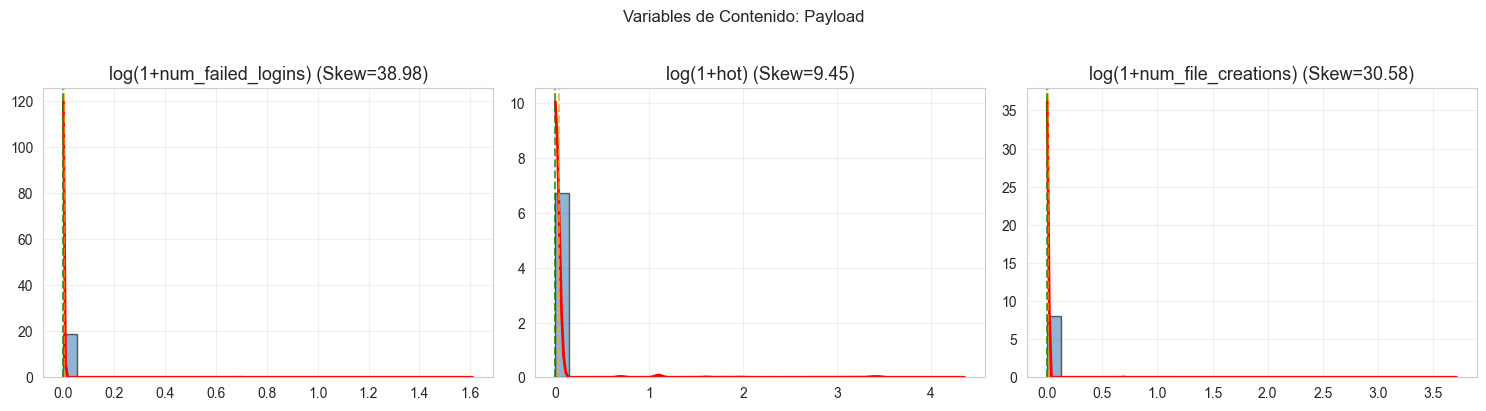

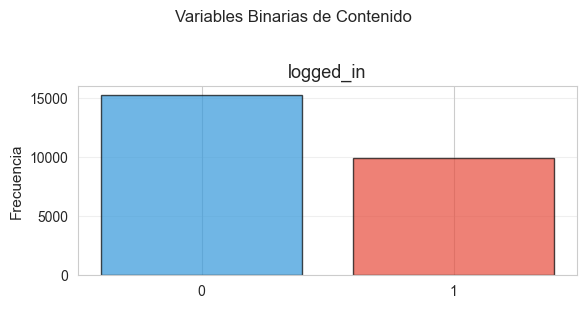

In [15]:
# Numéricas de contenido - transformación log por alta asimetría (Skew > 50)
content_viz = ['num_failed_logins', 'hot', 'num_file_creations']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, var in zip(axes, content_viz):
    data = np.log1p(train_df[var].dropna())
    
    ax.hist(data, bins=30, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    if data.std() > 0:
        kde = scipy.stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2)
    
    ax.axvline(data.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'log(1+{var}) (Skew={data.skew():.2f})')
    ax.grid(alpha=0.3)

plt.suptitle('Variables de Contenido: Payload', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Variables binarias de contenido
content_binary_viz = binary_analysis.loc[
    binary_analysis.index.isin(content_binary) & (binary_analysis['Varianza'] > 0.01)
].index.tolist()

fig, axes = plt.subplots(1, len(content_binary_viz), figsize=(6, 3))
if len(content_binary_viz) == 1:
    axes = [axes]

for ax, var in zip(axes, content_binary_viz):
    counts = train_df[var].value_counts().sort_index()
    ax.bar(['0', '1'], counts, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
    ax.set_title(f'{var}')
    ax.set_ylabel('Frecuencia')
    ax.grid(alpha=0.3, axis='y')

plt.suptitle('Variables Binarias de Contenido', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

#### 2.3.3 Variables de Tráfico Temporal (Ventana 2s)

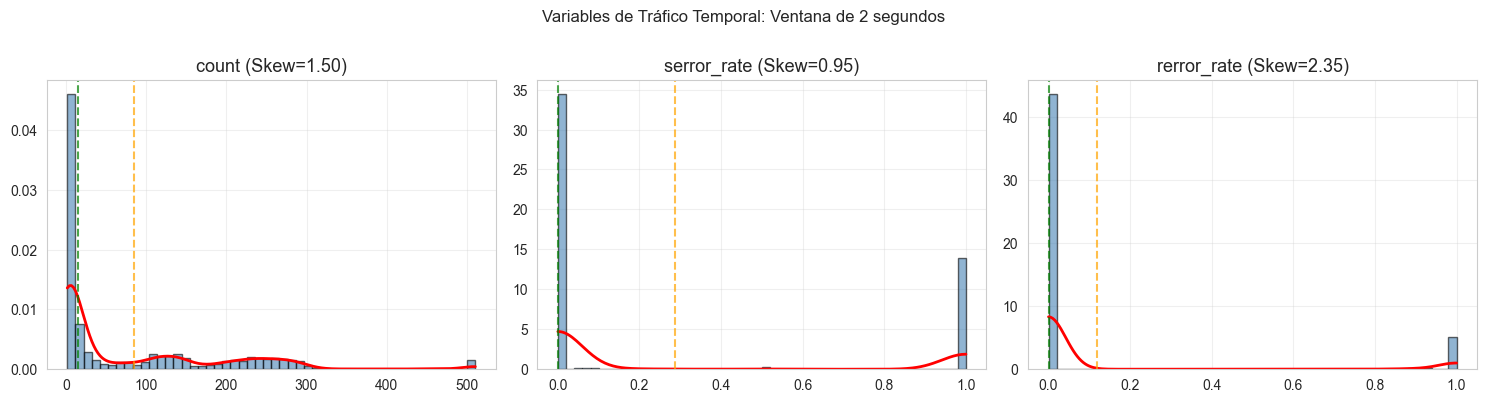

In [16]:
# Variables temporales más relevantes
temporal_viz = ['count', 'serror_rate', 'rerror_rate']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

for ax, var in zip(axes, temporal_viz):
    data = train_df[var].dropna()
    
    ax.hist(data, bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    if data.std() > 0:
        kde = scipy.stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2)
    
    ax.axvline(data.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{var} (Skew={data.skew():.2f})')
    ax.grid(alpha=0.3)

plt.suptitle('Variables de Tráfico Temporal: Ventana de 2 segundos', fontsize=12, y=1.00)
plt.tight_layout()
plt.show()

#### 2.3.4 Variables Basadas en Host (Últimas 100 conexiones)

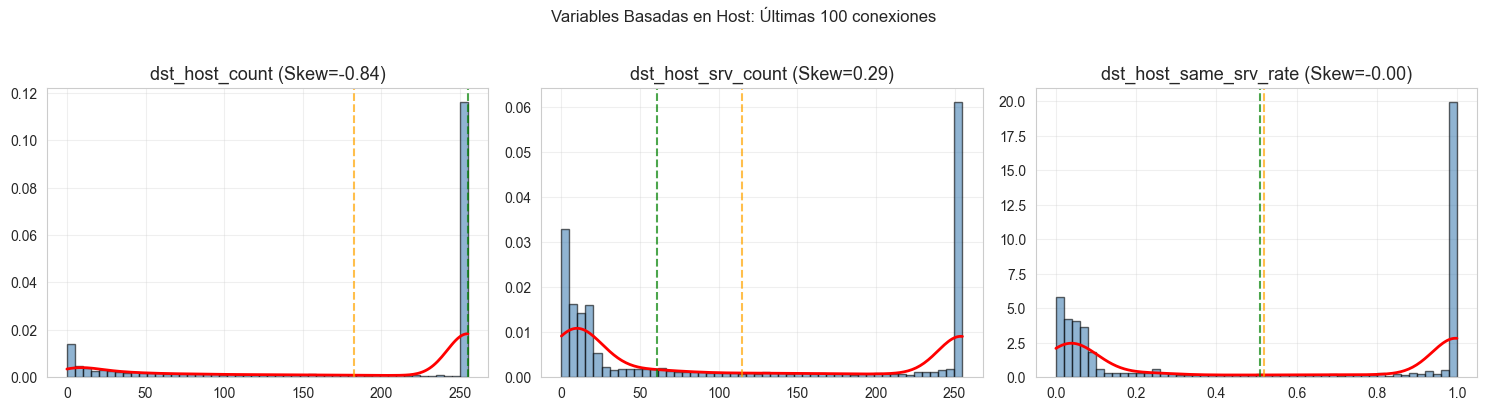

In [17]:
# Variables basadas en host más relevantes
host_viz = ['dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, var in zip(axes, host_viz):
    data = train_df[var].dropna()
    
    ax.hist(data, bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    if data.std() > 0:
        kde = scipy.stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2)
    
    ax.axvline(data.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{var} (Skew={data.skew():.2f})')
    ax.grid(alpha=0.3)

plt.suptitle('Variables Basadas en Host: Últimas 100 conexiones', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

####
- Las variables básicas (duration, src_bytes, dst_bytes) presentan asimetría positiva incluso tras la transformación log(1+x), reflejando la coexistencia de muchas conexiones cortas con pocas conexiones de gran duración o volumen, un patrón típico del tráfico de red.

- Las variables de contenido muestran una concentración extrema en cero y colas largas residuales, indicando que representan eventos discretos raros.

- Las variables de tráfico temporal exhiben distribuciones más estructuradas, destacando la bimodalidad en tasas de error (serror_rate, rerror_rate), lo que sugiere la presencia de regímenes diferenciados de comportamiento normal y anómalo.

- Las variables basadas en host presentan picos pronunciados y concentraciones en valores extremos, evidenciando patrones repetitivos hacia hosts o servicios específicos.

- Entre las binarias, solo logged_in tiene varianza suficiente.


### 2.4 Análisis de Valores Extremos

En la mayoría de los análisis estadísticos, los valores extremos (outliers) se consideran errores de medición y se eliminan. Sin embargo, en detección de intrusiones esta lógica se invierte: los valores extremos frecuentemente son la manifestación del comportamiento anómalo que buscamos identificar.

Consideremos una analogía: en un sistema de monitoreo de transacciones bancarias, un usuario normal gasta $50, $100, o quizás $200. Un atacante intentando robar podría hacer una transacción de $50,000. Si tratamos los $50,000 como un outlier y lo eliminamos, estamos eliminando al ladrón.

En el dataset NSL-KDD ocurre exactamente lo mismo. El tráfico normal envía pequeñas cantidades de bytes, mientras que los ataques DoS envían millones de bytes para saturar el servidor. Los "puntos superiores" en los boxplots no son errores: son los ataques que queremos detectar.

#### 2.4.1 Comparación de distribuciones: Normal vs Ataque

Analizamos tres variables representativas que demuestran patrones diferentes de valores extremos: volumen de tráfico, ráfagas de conexiones y duración temporal.

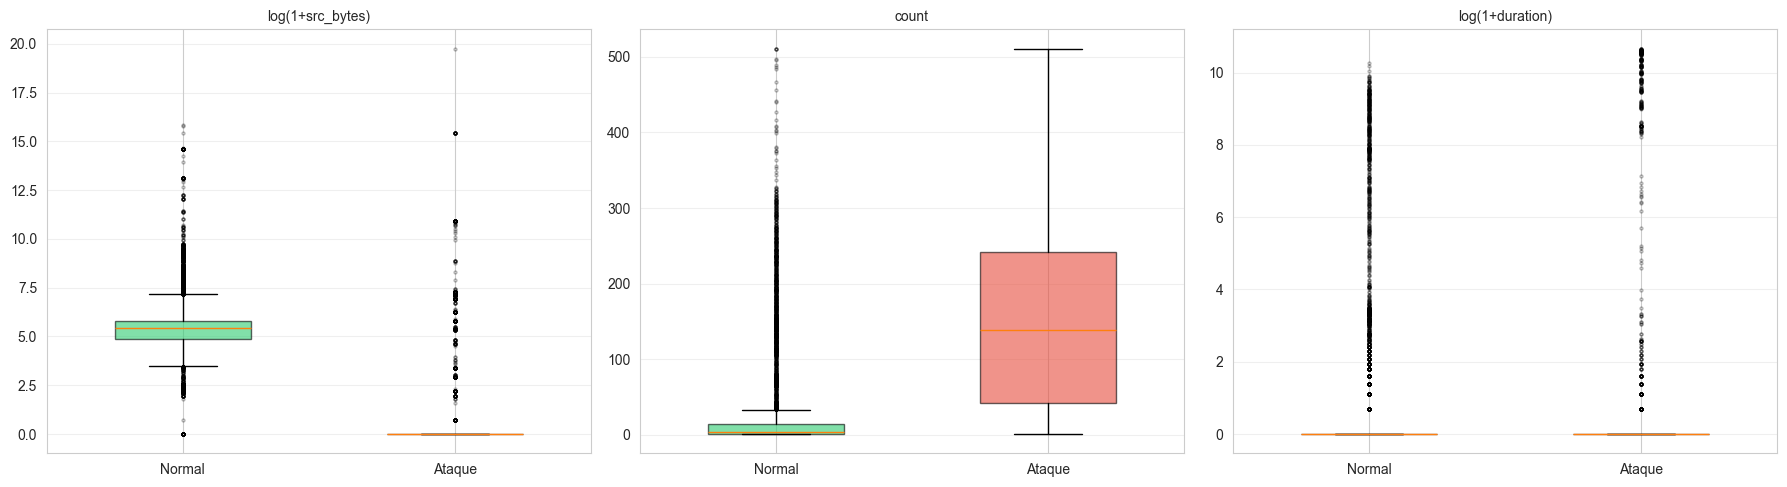

In [18]:
# Variables seleccionadas: cada una demuestra un patrón diferente
cols_to_plot = ['src_bytes', 'count', 'duration']
log_cols = ['src_bytes', 'duration']

train_df['is_attack'] = (train_df['attack_category'] != 'Normal').astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(cols_to_plot):
    ax = axes[idx]
    
    normal = train_df.loc[train_df['is_attack'] == 0, col].dropna()
    attack = train_df.loc[train_df['is_attack'] == 1, col].dropna()
    
    y_label = col
    if col in log_cols:
        normal = np.log1p(normal)
        attack = np.log1p(attack)
        y_label = f'log(1+{col})'
    
    bp = ax.boxplot([normal, attack], labels=['Normal', 'Ataque'],
                   patch_artist=True, widths=0.5, showfliers=True,
                   flierprops=dict(marker='o', markersize=2, alpha=0.3))
    
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][1].set_alpha(0.6)
    
    ax.set_title(y_label, fontsize=10)
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

-**src_bytes** tras la transformación logarítmica, Normal presenta una caja compacta y centrada mientras que Ataque muestra una caja reducida cerca de 0 con outliers dispersos hacia valores superiores, reflejando que los ataques pueden enviar desde cantidades mínimas hasta volúmenes masivos de datos.

-**count** muestra cómo Normal se concentra en valores muy bajos mientras que Ataque presenta una caja desplazada significativamente hacia valores superiores, evidenciando ráfagas de conexiones simultáneas típicas de ataques de denegación de servicio y escaneo.

-**duration** presenta valores extremos en ambas clases pero con distribuciones marcadamente diferentes: Normal con outliers superiores esporádicos, Ataque con mayor dispersión que incluye tanto conexiones instantáneas como persistentes.

**Decisión: mantener todos los valores extremos.** Representan comportamiento anómalo discriminativo.

### 2.5 Análisis Bivariado: Asociaciones y Multicolinealidad

#### 2.5.1 Asociaciones categóricas

Analizamos si variables categóricas (protocol_type, service, flag) están asociadas con categorías de ataque específicas mediante tablas de contingencia.

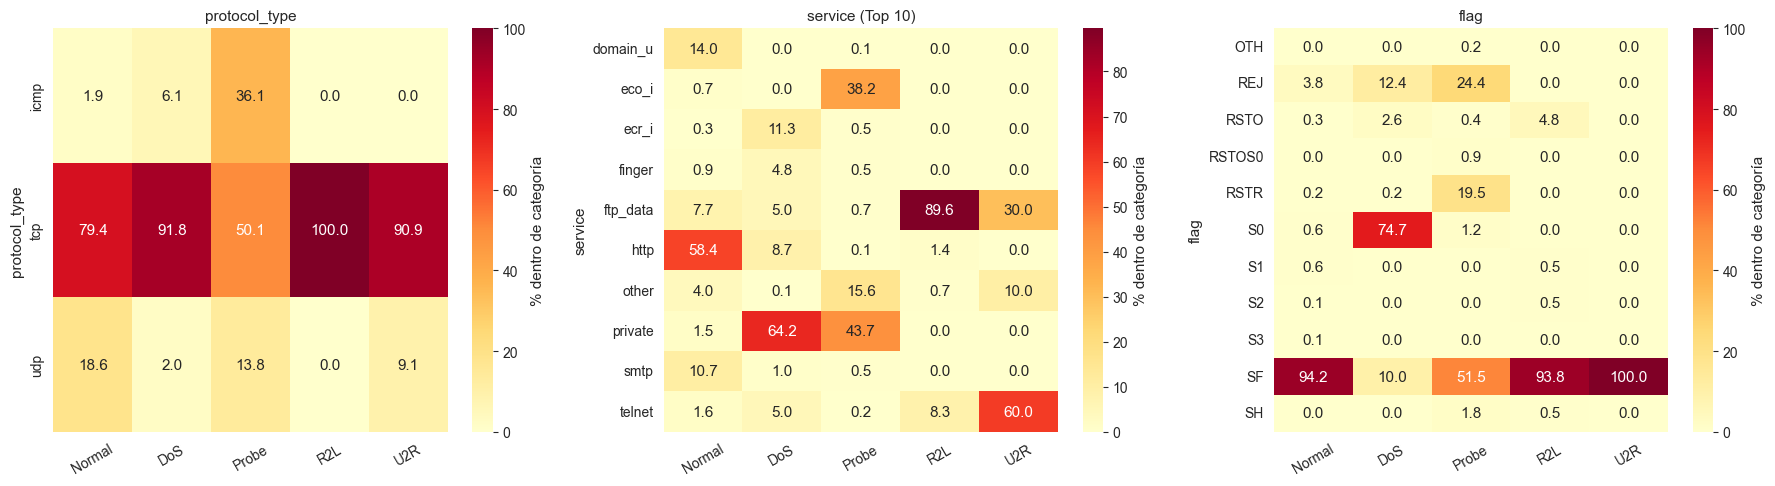

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

categorical_vars = ['protocol_type', 'service', 'flag']

for idx, var in enumerate(categorical_vars):
    ax = axes[idx]
    
    if var == 'service':
        top_services = train_df['service'].value_counts().head(10).index
        contingency = pd.crosstab(
            train_df[train_df['service'].isin(top_services)]['service'],
            train_df[train_df['service'].isin(top_services)]['attack_category'],
            normalize='columns'
        ) * 100
    else:
        contingency = pd.crosstab(
            train_df[var], 
            train_df['attack_category'],
            normalize='columns'
        ) * 100
    
    sns.heatmap(contingency, annot=True, fmt='.1f', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': '% dentro de categoría'})
    
    title = f'{var}' if var != 'service' else f'{var} (Top 10)'
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

- **protocol_type** muestra asociación clara: TCP es mayoritario en todas las categorías de ataque. ICMP es distintivo de Probe (36.1%).

- **service** presenta patrones específicos: http caracteriza Normal (58.4%), private domina en DoS (64.2%) y también Probe (43.7%) junto a eco_i, ftp_data es fuerte en R2L (89.6%), y telnet es exclusivo de U2R (60%).

- **flag** muestra ascociación clara también: SF (conexión exitosa) domina Normal (94.2%), Probe (51.5%), R2L(93.8%) y U2R(100%), mientras que REJ (rechazada) es distintivo de Probe (24.4%) y  S0 (sin respuesta) caracteriza DoS (74.7%)

#### 2.5.2 Multicolinealidad entre variables numéricas

Visualizamos la matriz de correlación completa para identificar redundancia informativa entre variables numéricas.

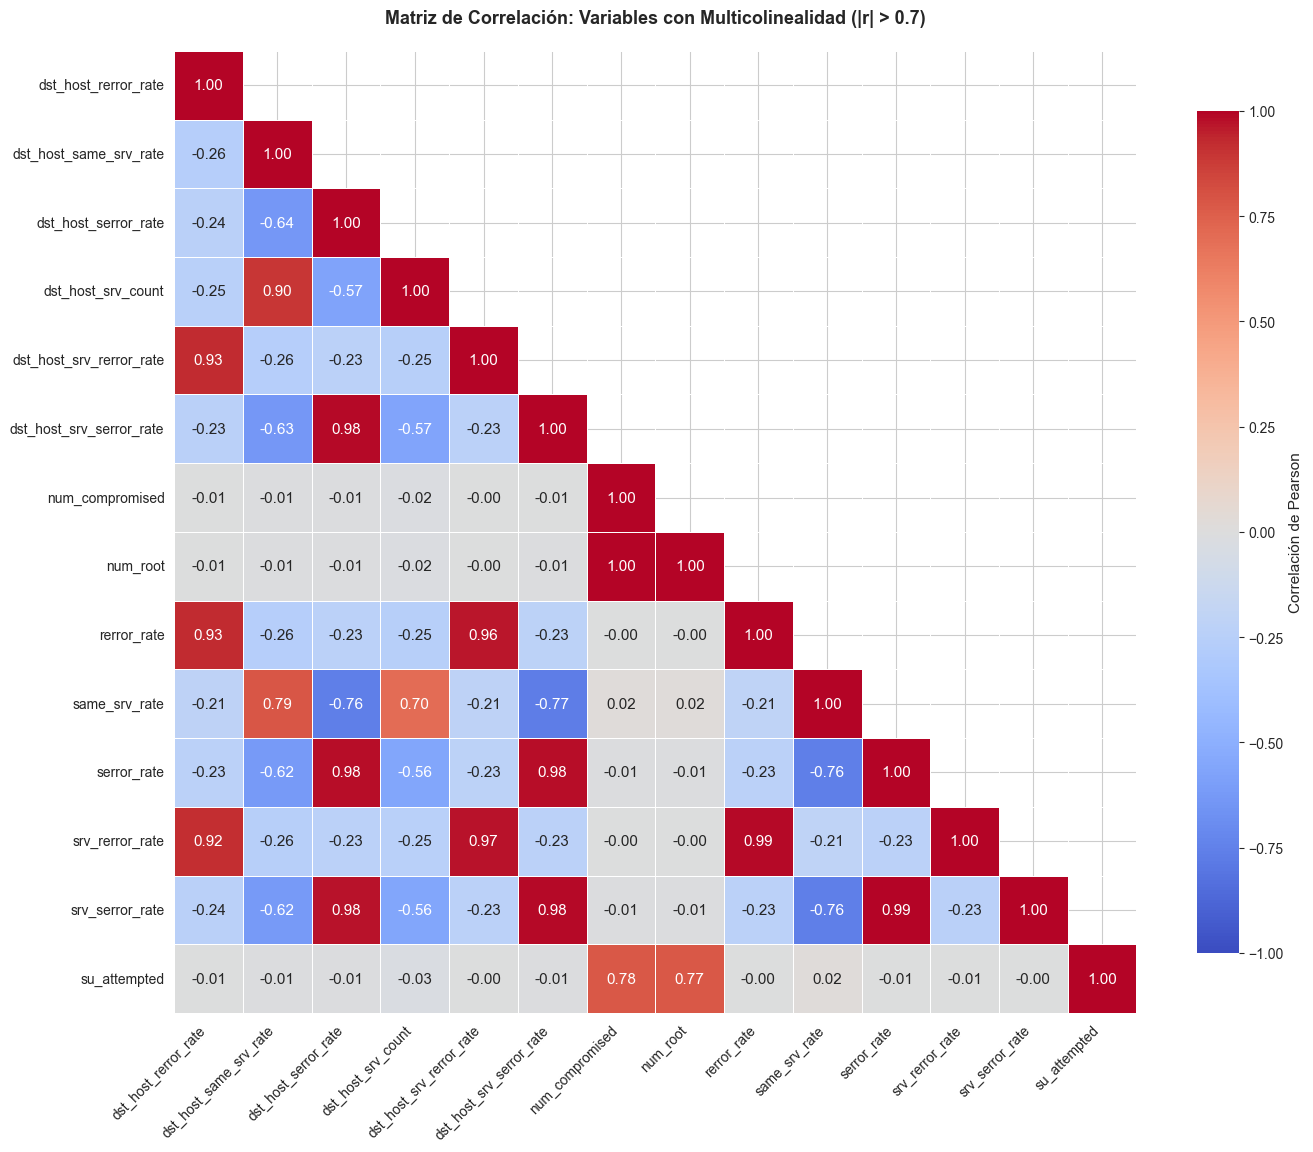

In [20]:
# Calcular matriz de correlación
numeric_for_corr = [v for v in continuous_vars 
                    if v not in zero_variance_vars and v in train_df.columns]

corr_matrix = train_df[numeric_for_corr].corr()

# Identificar variables con al menos una correlación alta
vars_with_high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            vars_with_high_corr.add(corr_matrix.columns[i])
            vars_with_high_corr.add(corr_matrix.columns[j])

vars_with_high_corr = sorted(vars_with_high_corr)

# Submatriz solo con variables problemáticas
corr_subset = corr_matrix.loc[vars_with_high_corr, vars_with_high_corr]

# Heatmap reducido
fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)

sns.heatmap(
    corr_subset, 
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Correlación de Pearson', 'shrink': 0.8},
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_title('Matriz de Correlación: Variables con Multicolinealidad (|r| > 0.7)', 
             fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


Se identifican 14 variables con al menos una correlación |r| > 0.7, agrupadas en tres clusters principales:

- **Cluster 1 - Tasas de error (r ≈ 0.93-0.99):** Las variables serror_rate, srv_serror_rate, dst_host_serror_rate y dst_host_srv_serror_rate forman un grupo altamente correlacionado (r > 0.98), midiendo errores SYN a diferentes niveles de agregación. El mismo patrón se observa en rerror_rate y sus variantes (dst_host_rerror_rate, dst_host_srv_rerror_rate, srv_rerror_rate) con r > 0.92. Estas correlaciones indican que las tasas de error locales predicen fuertemente las tasas globales del host.

- **Cluster 2 - Variables de compromiso (r = 0.77-1.00):** num_compromised y num_root presentan correlación casi perfecta (r = 1.00), ambas correlacionadas con su_attempted (r ≈ 0.77-0.78). Este cluster representa facetas del mismo evento de escalada de privilegios, resultando en redundancia informativa total.

- **Cluster 3 - Monotonía del tráfico (r = 0.70-0.90):** same_srv_rate, dst_host_same_srv_rate y dst_host_srv_count forman un tercer grupo, donde conexiones repetidas al mismo servicio se reflejan consistentemente en las métricas basadas en host (r = 0.79-0.90).

- **Correlaciones negativas (r ≈ -0.76 a -0.77):** same_srv_rate se correlaciona negativamente con las tasas de error de serror, indicando que conexiones exitosas repetidas al mismo servicio implican bajas tasas de error SYN.

### 2.6 Preguntas de Investigación

Este proyecto aborda tres preguntas fundamentales sobre el análisis estadístico del tráfico de red para detección de intrusiones.

---

**Pregunta 1: ¿Qué variables del tráfico de red presentan diferencias estadísticamente significativas entre categorías de ataque y cuál es la magnitud del efecto discriminante?**

El EDA reveló que las distribuciones violan sistemáticamente el supuesto de normalidad (asimetría > 10 en src_bytes, dst_bytes, duration) y presentan varianzas heterogéneas. Bajo estas condiciones, las pruebas paramétricas son inválidas. Necesitamos cuantificar la magnitud del efecto para identificar qué variables son más discriminantes.

**Técnicas:** Kruskal-Wallis (α = 0.05), post-hoc de Dunn con corrección de Bonferroni, coeficiente η² para rankear variables por poder discriminante.

---

**Pregunta 2: ¿Cuántos componentes principales son necesarios para capturar la estructura discriminante del tráfico de red?**

El análisis de multicolinealidad identificó 14 variables con |r| > 0.7, agrupados en tres clusters: tasas de error (r > 0.98), variables de compromiso (r = 1.00), y monotonía del tráfico (r = 0.70-0.90). Esta redundancia genera inestabilidad numérica, sobreajuste, e imposibilidad de visualización en > 3D.

**Técnicas:** PCA, scree plot , interpretación de loadings (|loading| > 0.3), biplot 2D para visualizar separabilidad.

---

**Pregunta 3: ¿Qué componentes principales son estadísticamente significativos para explicar la pertenencia a cada categoría de ataque?**

Mediante regresión logística binaria (DoS vs Resto, Probe vs Resto, R2L vs Resto, U2R vs Resto), se determina qué componentes tienen coeficientes significativos (p < 0.05) según test de Wald, cuantificando la magnitud del efecto con odds ratios y verificando bondad de ajuste mediante diagnóstico de residuos.

**Técnicas:** Regresión logística, test de Wald, odds ratios, test de razón de verosimilitud, diagnóstico de residuos (Pearson, deviance, Cook's D), verificación de supuestos.

---

P1 identifica variables discriminantes y cuantifica efectos. P2 comprime eliminando redundancia. P3 determina qué componentes explican significativamente cada tipo de ataque.

---

## 3. Preparación de Datos.

---

### 3.1 Selección de Variables para el Análisis

El objetivo de esta sección es **etener únicamente las variables que contribuyen al análisis estadístico** , eliminando aquellas sin variabilidad o redundancia informativa extrema.

#### Criterios de exclusión

Se excluyen variables que cumplen alguno de los siguientes criterios:

- **Varianza nula (Var = 0):** variables constantes que no contienen información.
- **Variables binarias casi constantes:** varianza < 0.01, lo que indica presencia casi exclusiva de un solo valor.
- **Variables metadata:** utilizadas solo para etiquetado o evaluación, no para inferencia estadística.

In [21]:
# Variables a eliminar
zero_variance = zero_variance_continuous = descriptive_stats[
    descriptive_stats['Desv_Std'] == 0
].index.tolist()

low_variance_binary = binary_analysis[
    binary_analysis['Varianza'] < 0.01
].index.tolist()


metadata_vars = ['attack_type', 'difficulty_level', 'is_attack']

vars_to_drop = zero_variance + low_variance_binary + metadata_vars

# Variables numéricas finales
numeric_final = [v for v in continuous_vars if v not in vars_to_drop]
binary_final = [v for v in binary_vars if v not in vars_to_drop]

# Variables categóricas (sin cambios)
categorical_final = ['protocol_type', 'service', 'flag']

print(f"Variables numéricas continuas: {len(numeric_final)}")
print(f"Variables binarias: {len(binary_final)}")
print(f"Variables categóricas: {len(categorical_final)}")
print(f"\nTotal variables para análisis: {len(numeric_final) + len(binary_final)}")

Variables numéricas continuas: 33
Variables binarias: 1
Variables categóricas: 3

Total variables para análisis: 34


### 3.2 Tratamiento de Variables Categóricas

**Decisión:** Las variables categóricas (protocol_type, service, flag) no se incluirán en el análisis mediante PCA ni en los modelos de regresión logística.

**Justificación:** El Análisis de Componentes Principales requiere variables numéricas continuas. La aplicación de codificación one-hot sobre variables categóricas introduce alta esparsidad, incrementa artificialmente la dimensionalidad y dificulta la interpretación de los loadings, comprometiendo la utilidad analítica del método. De forma análoga, en regresión logística la inclusión de un elevado número de variables dummy reduce la interpretabilidad de los coeficientes y puede generar inestabilidad numérica.

La información contenida en estas variables no se descarta: su relación con las categorías de ataque fue evaluada previamente mediante análisis bivariado (Sección 2.5.1) utilizando tablas de contingencia y medidas de asociación apropiadas. De este modo, el análisis multivariante posterior se centra exclusivamente en variables numéricas, manteniendo coherencia estadística y claridad metodológica.


### 3.3 Estandarización de Variables Numéricas

El objetivo de esta sección es **transformar las variables numéricas a una escala común**, con media cero y desviación estándar uno, para PCA y regresión logística. Asi evitamos que variables con varianza absoluta elevada dominan artificialmente los primeros componentes de **PCA** y obtenemos coeficientes más interpretables y convergencia más rápida en la **Regresión Logística**.

#### Método aplicado

Se utiliza **StandardScaler** (media = 0, desviación = 1)

In [22]:
from sklearn.preprocessing import StandardScaler

# Combinar numéricas continuas y binarias
all_numeric = numeric_final + binary_final

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[all_numeric])

# Convertir a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=all_numeric, index=train_df.index)

print(f"Media global: {X_scaled_df.mean().mean():.6f} (esperado: 0)")
print(f"Desv. Std. global: {X_scaled_df.std().mean():.6f} (esperado: 1)")
print(f"\nDimensiones: {X_scaled_df.shape}")

Media global: 0.000000 (esperado: 0)
Desv. Std. global: 1.000020 (esperado: 1)

Dimensiones: (25192, 34)


### 3.4 Creación de Variables Target para Regresión Logística

El objetico de esta sección es construir 4 variables binarias para modelos **one-vs-rest** (DoS vs Resto, Probe vs Resto, R2L vs Resto, U2R vs Resto).

In [23]:
# Crear targets binarios
train_df['target_DoS'] = (train_df['attack_category'] == 'DoS').astype(int)
train_df['target_Probe'] = (train_df['attack_category'] == 'Probe').astype(int)
train_df['target_R2L'] = (train_df['attack_category'] == 'R2L').astype(int)
train_df['target_U2R'] = (train_df['attack_category'] == 'U2R').astype(int)

# Verificar proporciones
print("PROPORCIONES DE CLASES POSITIVAS:")
for attack in ['DoS', 'Probe', 'R2L', 'U2R']:
    prop = train_df[f'target_{attack}'].mean()
    n_pos = train_df[f'target_{attack}'].sum()
    print(f"  {attack:6s}: {prop*100:5.2f}% ({n_pos:,} observaciones)")

PROPORCIONES DE CLASES POSITIVAS:
  DoS   : 36.65% (9,234 observaciones)
  Probe :  9.09% (2,289 observaciones)
  R2L   :  0.83% (209 observaciones)
  U2R   :  0.04% (11 observaciones)


### 3.5 Conjunto de Datos Final para el Análisis Estadístico

Tras el análisis exploratorio y las decisiones de preparación, el conjunto de datos queda estructural y estadísticamente adecuado para responder las tres preguntas de investigación planteadas en la Sección 2.6.

Se eliminaron variables sin variabilidad o con varianza despreciable, resultando en un conjunto final de **34 variables numéricas** informativas. Las variables categóricas (*protocol_type, service, flag*) se excluyeron de los análisis multivariantes, manteniéndose únicamente para análisis descriptivos y bivariados, con el fin de preservar la coherencia metodológica y la interpretabilidad de los resultados.

Para el análisis de componentes principales, todas las variables numéricas fueron **estandarizadas** (media = 0, desviación estándar = 1), eliminando efectos de escala que podrían sesgar la descomposición de la varianza. En el caso del análisis no paramétrico (Kruskal–Wallis), se emplearon las variables originales, dado que la prueba opera sobre rangos y no requiere estandarización.

Finalmente, se construyeron **cuatro variables objetivo binarias** para regresión logística en un esquema one-vs-rest (DoS, Probe, R2L, U2R).

El dataset resultante no presenta valores faltantes ni inconsistencias estructurales, y cumple los supuestos técnicos necesarios para los análisis inferenciales y multivariantes posteriores.


#

---

## 4. Aplicación de técnicas estadísticas.

---

### 4.1 Pregunta 1: Diferencias Estadísticas entre Categorías de Ataque

#### 4.1.1 Verificación de Supuestos de Kruskal-Wallis

La prueba de Kruskal-Wallis requiere tres supuestos fundamentales: independencia de observaciones, variable dependiente ordinal o continua y distribuciones con formas similares entre grupos para interpretar diferencias como diferencias de medianas.


**Supuesto 1: Independencia de observaciones**

La prueba de Kruskal-Wallis asume que las observaciones son independientes entre sí. En el dataset NSL-KDD, cada registro corresponde a una conexión de red individual y se considera una unidad de análisis independiente, por lo que este supuesto se cumple por diseño del conjunto de datos.


**Supuesto 2: Tipo de variable**

La prueba de Kruskal-Wallis requiere que la variable dependiente sea al menos ordinal. Las variables analizadas **(src_bytes, dst_bytes, duration, count, srv_count, serror_rate, rerror_rate, same_srv_rate, dst_host_count, dst_host_srv_count)** son numéricas, continuas o discretas, por lo que este supuesto se cumple.


**Supuesto 3: Homogeneidad de varianzas (Test de Levene)**

El test de Levene evalúa si las varianzas de una variable son estadísticamente iguales entre dos o más grupos. Su hipótesis nula establece que todas las poblaciones comparadas presentan varianzas homogéneas. Un p-valor menor que α = 0.05 indica evidencia suficiente para rechazar dicha hipótesis y concluir que existen diferencias significativas en la dispersión entre los grupos.


In [24]:
from scipy.stats import levene
# Test de Levene para homogeneidad de varianzas

vars_to_test = [
    'src_bytes', 'dst_bytes', 'duration', 'count', 'srv_count',
    'serror_rate', 'rerror_rate', 'same_srv_rate',
    'dst_host_count', 'dst_host_srv_count'
]

results = []

for var in vars_to_test:
    groups = [
        train_df.loc[train_df['attack_category'] == cat, var].dropna()
        for cat in category_order
    ]
    
    stat, p_value = levene(*groups)
    
    results.append({
        'Variable': var,
        'Levene_stat': round(stat, 2),
        'p_value': f"{p_value:.4f}",
        'Varianzas_homogéneas': 'No' if p_value < 0.05 else 'Sí'
    })

levene_df = pd.DataFrame(results)
levene_df

,Variable,Levene_stat,p_value,Varianzas_homogéneas
0,src_bytes,3.09,0.0148,No
1,dst_bytes,111.33,0.0000,No
2,duration,361.62,0.0000,No
3,count,1167.55,0.0000,No
4,srv_count,35.80,0.0000,No
5,serror_rate,1040.15,0.0000,No
6,rerror_rate,922.15,0.0000,No
7,same_srv_rate,765.51,0.0000,No
8,dst_host_count,4272.14,0.0000,No
9,dst_host_srv_count,501.42,0.0000,No


**Implicaciones de la heterogeneidad de varianzas**

Todas las variables analizadas presentan varianzas heterogéneas entre categorías de ataque (p < 0.05 en el test de Levene), en concordancia con las distribuciones asimétricas y colas pesadas observadas en el EDA (Sección 2.3).

**Implicación estadística:**  
Bajo heterogeneidad de varianzas, la prueba de Kruskal-Wallis detecta **diferencias generales de distribución** (ubicación, dispersión y/o forma), no exclusivamente diferencias de medianas.

**Validez de la prueba:**  
La heterogeneidad de varianzas **no invalida** Kruskal-Wallis, ya que este método no paramétrico no asume homocedasticidad. La interpretación correcta es que *las distribuciones difieren entre categorías*, no necesariamente sus medianas.

**Relevancia para la Pregunta 1:**  
Esta interpretación es consistente con el objetivo del proyecto: identificar variables con comportamiento diferenciado entre tipos de ataque, independientemente del componente específico de la distribución afectado.

**Conclusión:** Los supuestos de Kruskal-Wallis se consideran adecuadamente cumplidos.


#### 4.1.2 Aplicación de la Prueba de Kruskal-Wallis

La prueba de Kruskal-Wallis es un contraste no paramétrico para comparar $k$ muestras independientes. Parte de la transformación de los datos originales en rangos globales, asignando el rango promedio en caso de empates.

Sea $N$ el tamaño muestral total, $n_j$ el número de observaciones del grupo $j$, y $R_j$ la suma de rangos del grupo $j$. El estadístico de contraste se define como:

$$
H = \frac{12}{N(N+1)} \sum_{j=1}^{k} \frac{R_j^2}{n_j} - 3(N+1)
$$

Bajo la hipótesis nula de igualdad de distribuciones entre grupos, $H$ sigue aproximadamente una distribución $\chi^2$ con $k-1$ grados de libertad. Valores grandes de $H$ indican diferencias globales entre las distribuciones de los grupos.

Dado que la significancia estadística depende del tamaño muestral, se cuantifica además la magnitud del efecto mediante el coeficiente $\eta^2$, definido como:

$$
\eta^2 = \frac{H - k + 1}{N - k}
$$

Este coeficiente estima la proporción de variabilidad explicada por la variable de agrupación. Siguiendo criterios estándar, el tamaño del efecto se interpreta como pequeño ($\eta^2 < 0.06$), mediano ($0.06 \leq \eta^2 < 0.14$) o grande ($\eta^2 \geq 0.14$).


In [25]:
from scipy.stats import kruskal
# Test de Kruskal-Wallis para diferencias entre categorías
kw_results = []

for var in vars_to_test:
    # Separar por categoría
    groups = [train_df[train_df['attack_category'] == cat][var].dropna() 
              for cat in category_order]
    
    # Test de Kruskal-Wallis
    h_stat, p_value = kruskal(*groups)
    
    # Calcular η² (eta cuadrado)
    n = sum(len(g) for g in groups)
    k = len(groups)
    eta_squared = (h_stat - k + 1) / (n - k)
    
    # Clasificar tamaño del efecto
    if eta_squared < 0.06:
        effect_size = 'Pequeño'
    elif eta_squared < 0.14:
        effect_size = 'Mediano'
    else:
        effect_size = 'Grande'
    
    kw_results.append({
        'Variable': var,
        'H_statistic': round(h_stat, 2),
        'p_value': p_value,
        'eta_squared': round(eta_squared, 4),
        'Efecto': effect_size,
        'Significativo': 'Sí' if p_value < 0.05 else 'No'
    })

kw_df = pd.DataFrame(kw_results).sort_values('eta_squared', ascending=False)
print(kw_df.to_string(index=False))

# Resumen
n_sig = (kw_df['Significativo'] == 'Sí').sum()
print(f"Variables con diferencias significativas (p < 0.05): {n_sig}/{len(vars_to_test)}")
print(f"Variables con efecto grande (η² > 0.14): {(kw_df['Efecto'] == 'Grande').sum()}")

          Variable  H_statistic  p_value  eta_squared  Efecto Significativo
     same_srv_rate     15991.64      0.0       0.6348  Grande            Sí
       serror_rate     14443.03      0.0       0.5733  Grande            Sí
         dst_bytes     14431.55      0.0       0.5728  Grande            Sí
         src_bytes     13667.44      0.0       0.5425  Grande            Sí
             count     12515.80      0.0       0.4968  Grande            Sí
dst_host_srv_count     11838.25      0.0       0.4699  Grande            Sí
    dst_host_count      6475.69      0.0       0.2569  Grande            Sí
       rerror_rate      3195.31      0.0       0.1267 Mediano            Sí
         srv_count      1724.89      0.0       0.0683 Mediano            Sí
          duration      1476.36      0.0       0.0585 Pequeño            Sí
Variables con diferencias significativas (p < 0.05): 10/10
Variables con efecto grande (η² > 0.14): 7


#### 4.1.3 Prueba Post-Hoc de Dunn con Corrección de Bonferroni

La prueba post-hoc de Dunn es un contraste no paramétrico diseñado para realizar comparaciones *par a par* entre $k$ grupos independientes cuando la prueba de Kruskal–Wallis ha rechazado la hipótesis nula global.

Al igual que Kruskal–Wallis, la prueba de Dunn opera sobre los **rangos globales** de las observaciones. Para cada par de grupos $(i, j)$, se compara la diferencia entre sus rangos promedio. El estadístico de contraste se define como:

$$
Z_{ij} = \frac{\bar{R}_i - \bar{R}_j}
{\sqrt{\frac{N(N+1)}{12}\left(\frac{1}{n_i} + \frac{1}{n_j}\right)}}
$$

donde:
- $N$ es el tamaño muestral total,
- $n_i, n_j$ son los tamaños muestrales de los grupos $i$ y $j$,
- $\bar{R}_i, \bar{R}_j$ son los rangos promedio de los grupos comparados.

Bajo la hipótesis nula de igualdad de distribuciones entre los dos grupos, el estadístico $Z_{ij}$ sigue aproximadamente una distribución normal estándar $\mathcal{N}(0,1)$.

Dado que se realizan múltiples comparaciones simultáneas, los valores *p* se ajustan para controlar el error tipo I familiar. En este estudio se emplea la corrección de Bonferroni, definida como:

$$
p_{\text{ajustado}} = \min(m \cdot p,\, 1)
$$

donde $m$ es el número total de comparaciones *par a par*.

La prueba de Dunn permite así identificar qué pares específicos de categorías explican las diferencias globales detectadas por la prueba de Kruskal–Wallis.


In [26]:
from scikit_posthocs import posthoc_dunn

# Analizar las 3 variables con mayor η²
top_3_vars = kw_df.head(3)['Variable'].tolist()

for var in top_3_vars:
    print(f"\n{'─'*70}")
    print(f"Variable: {var}")
    eta2 = kw_df[kw_df['Variable'] == var]['eta_squared'].values[0]
    print(f"η² = {eta2:.4f}")
    print(f"{'─'*70}\n")
    
    # Test de Dunn
    dunn_results = posthoc_dunn(
        train_df, 
        val_col=var, 
        group_col='attack_category',
        p_adjust='bonferroni'
    )
    
    print(dunn_results.round(4).to_string())
    
    # Identificar pares significativos
    significant_pairs = []
    for i in range(len(category_order)):
        for j in range(i+1, len(category_order)):
            cat1 = category_order[i]
            cat2 = category_order[j]
            p_val = dunn_results.loc[cat1, cat2]
            if p_val < 0.05:
                significant_pairs.append(f"{cat1}-{cat2} (p={p_val:.4f})")
    
    print(f"\nPares con diferencias significativas (p < 0.05): {len(significant_pairs)}")
    if len(significant_pairs) <= 5:
        for pair in significant_pairs:
            print(f"  • {pair}")


──────────────────────────────────────────────────────────────────────
Variable: same_srv_rate
η² = 0.6348
──────────────────────────────────────────────────────────────────────

        Normal  DoS   Probe  R2L     U2R
Normal     1.0  0.0  0.0000  1.0  1.0000
DoS        0.0  1.0  0.0000  0.0  0.0000
Probe      0.0  0.0  1.0000  0.0  0.3522
R2L        1.0  0.0  0.0000  1.0  1.0000
U2R        1.0  0.0  0.3522  1.0  1.0000

Pares con diferencias significativas (p < 0.05): 6

──────────────────────────────────────────────────────────────────────
Variable: serror_rate
η² = 0.5733
──────────────────────────────────────────────────────────────────────

        Normal  DoS   Probe     R2L  U2R
Normal     1.0  0.0  0.0000  1.0000  1.0
DoS        0.0  1.0  0.0000  0.0000  0.0
Probe      0.0  0.0  1.0000  0.0013  1.0
R2L        1.0  0.0  0.0013  1.0000  1.0
U2R        1.0  0.0  1.0000  1.0000  1.0

Pares con diferencias significativas (p < 0.05): 6

─────────────────────────────────────────────

---

**Hallazgos principales:**

Todas las variables analizadas presentan diferencias estadísticamente significativas entre categorías de ataque (H con p < 0.001 en todos los casos). Siete variables exhiben tamaño del efecto grande (η² > 0.14), dos efecto mediano, y una efecto pequeño.

Las tres variables con mayor poder discriminante son:

1. **same_srv_rate** (η² = 0.6348): Presenta el efecto más fuerte, explicando 63.5% de la variabilidad entre categorías. El post-hoc de Dunn revela 6 pares significativamente diferentes: Normal y R2L/U2R se comportan similarmente (p = 1.0), mientras que DoS difiere de todas las categorías . Esto indica que la monotonía del tráfico (conexiones repetidas al mismo servicio) discrimina fuertemente entre ataques de volumen (DoS) versus comportamiento normal o ataques sigilosos.

2. **serror_rate** (η² = 0.5733): Segundo mayor efecto discriminante. Probe se diferencia significativamente de Normal, DoS y R2L (p < 0.0013), confirmando que las altas tasas de error SYN son características distintivas de escaneos de puertos.

3. **dst_bytes** (η² = 0.5728): Presenta 8 pares significativamente diferentes, el mayor número entre las tres variables analizadas. DoS y Probe difieren de todas las demás categorías pero no entre sí (p = 1.0), sugiriendo patrones similares de volumen recibido.

**Respuesta a Pregunta 1:** Las variables del tráfico de red presentan diferencias estadísticamente significativas entre categorías de ataque, con magnitudes de efecto que van desde pequeño (duration, η² = 0.06) a grande (same_srv_rate, serror_rate, dst_bytes, src_bytes, count con η² > 0.49). Las variables relacionadas con monotonía del tráfico (same_srv_rate), tasas de error (serror_rate, rerror_rate), y volumen de datos (dst_bytes, src_bytes, count) son las más discriminantes, estableciendo que cada tipo de ataque tiene una huella estadística diferenciada en el comportamiento de red.

### 4.2 Pregunta 2: Reducción Dimensional mediante PCA

#### 4.2.1 Verificación de Supuestos de PCA

El Análisis de Componentes Principales (PCA) es una técnica de reducción dimensional que transforma un conjunto de variables posiblemente correlacionadas en un conjunto menor de variables no correlacionadas llamadas componentes principales. Su aplicabilidad requiere verificar cinco supuestos fundamentales.

In [27]:
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_kmo
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preparar datos
n = len(X_scaled_df)
p = X_scaled_df.shape[1]

print(f"Número de observaciones: {n:,}")
print(f"Número de variables: {p}")

Número de observaciones: 25,192
Número de variables: 34


**Supuesto 1: Tamaño muestral adecuado**

PCA requiere un número suficiente de observaciones relativo al número de variables. Los criterios mínimos establecidos son: $n > 150$ (tamaño absoluto) y $n/p > 5$ (ratio observaciones-variables).

En el dataset analizado: $n = 25{,}192$ observaciones y $p = 34$ variables, resultando en $n/p = 740.9$. Ambos criterios se cumplen ampliamente, garantizando estabilidad en las estimaciones de correlación y eigenvalores.

**Supuesto 2: Presencia de correlaciones entre variables**

PCA requiere que existan correlaciones sustanciales entre las variables originales para que la reducción dimensional sea efectiva. Si las variables son independientes (matriz de correlación ≈ identidad), PCA no aporta beneficio alguno.

El análisis de correlaciones de la Sección 2.5 identificó:
- **14 variables** con correlación $|r| > 0.7$ (colinealidad severa)
- Correlación máxima: $r = 0.997$ entre `num_root` y `num_compromised`

La presencia de correlaciones sustanciales y multicolinealidad severa confirma que **PCA es apropiado**: las variables contienen información redundante que puede comprimirse en componentes ortogonales de

**Supuesto 3: Ausencia de multicolinealidad perfecta**

PCA requiere que no existan combinaciones lineales exactas entre variables (correlación $|r| = 1$), ya que esto provoca singularidad en la matriz de correlación e impide el cálculo de eigenvalores.
La correlación máxima observada es $r = 0.997$ y no se detectan pares con $|r| \geq 0.999$, no hay colinealidad perfecta. PCA puede proceder sin eliminación de variables.

**Supuesto 4: Linealidad de las relaciones**

PCA captura relaciones lineales mediante covarianzas/correlaciones. Relaciones no lineales no son detectadas y reducen la efectividad de la técnica. La verificación se realiza mediante inspección visual del par de variables con mayor correlación.

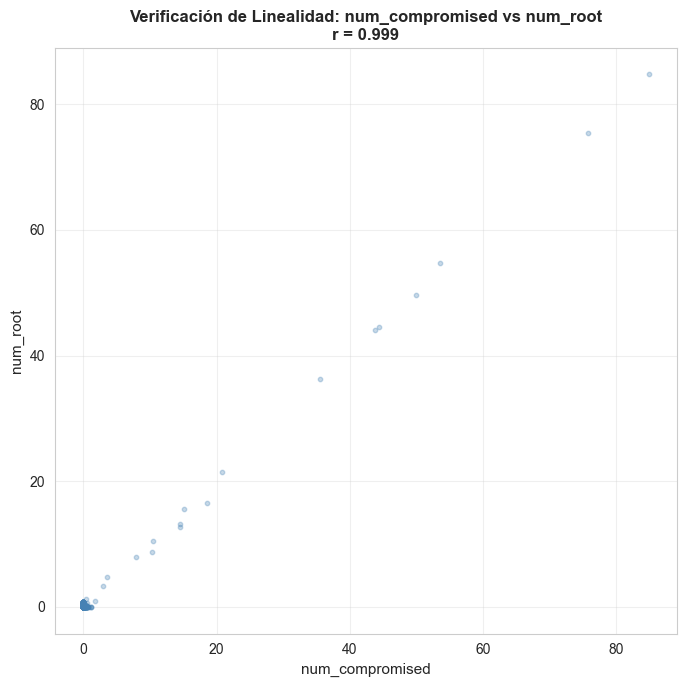

In [28]:
# Identificar par con mayor correlación
corr_matrix_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag.values, 0)

# Convertir a array de numpy para usar argmax
corr_array = corr_matrix_no_diag.values
max_corr_idx = np.unravel_index(np.abs(corr_array).argmax(), corr_array.shape)

var1 = corr_matrix.columns[max_corr_idx[0]]
var2 = corr_matrix.columns[max_corr_idx[1]]
corr_val = corr_matrix.loc[var1, var2]

# Gráfico de dispersión
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_scaled_df[var1], X_scaled_df[var2], alpha=0.3, s=10, color='steelblue')
ax.set_xlabel(var1, fontsize=11)
ax.set_ylabel(var2, fontsize=11)
ax.set_title(f'Verificación de Linealidad: {var1} vs {var2}\nr = {corr_val:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El scatter plot muestra una relación aproximadamente lineal entre las variables `num_root` y `num_compromised` ($r = 0.997$). Este patrón se replica en otras variables correlacionadas. El supuesto de linealidad es razonablemente satisfecho.

#### 4.2.2 Aplicación de PCA y Selección de Componentes

La descomposición en valores singulares (SVD) de la matriz de datos centrada y escalada $\mathbf{X}$ (dimensión $n \times p$) la factoriza como:

$$
\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T
$$

donde $\mathbf{U}$ ($n \times p$) contiene los vectores singulares izquierdos, $\boldsymbol{\Sigma}$ ($p \times p$) es diagonal con valores singulares $\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_p \geq 0$, y $\mathbf{V}$ ($p \times p$) contiene los vectores singulares derechos.

Los **componentes principales** son las proyecciones $\mathbf{T} = \mathbf{U}\boldsymbol{\Sigma}$, y los **loadings** (pesos) son las columnas de $\mathbf{V}$. La varianza explicada por el componente $k$ es proporcional al cuadrado de su valor singular:

$$
\lambda_k = \frac{\sigma_k^2}{\sum_{j=1}^p \sigma_j^2}
$$

La varianza acumulada hasta el componente $m$ es $\sum_{k=1}^m \lambda_k$, representando la proporción de información total retenida.

In [29]:
# Aplicar PCA con todos los componentes
pca = PCA()
pca_components = pca.fit_transform(X_scaled_df)

# Varianza explicada
var_explained = pca.explained_variance_ratio_
var_cumsum = var_explained.cumsum()

# Mostrar varianza de los primeros 15 componentes
print("Varianza explicada por componente:")
print("="*50)
for i in range(min(15, len(var_explained))):
    print(f"PC{i+1:2d}: {var_explained[i]:.4f} ({var_explained[i]*100:5.2f}%) | Acumulada: {var_cumsum[i]:.4f} ({var_cumsum[i]*100:5.2f}%)")
print("="*50)

Varianza explicada por componente:
PC 1: 0.2058 (20.58%) | Acumulada: 0.2058 (20.58%)
PC 2: 0.1439 (14.39%) | Acumulada: 0.3497 (34.97%)
PC 3: 0.1070 (10.70%) | Acumulada: 0.4567 (45.67%)
PC 4: 0.0552 ( 5.52%) | Acumulada: 0.5120 (51.20%)
PC 5: 0.0475 ( 4.75%) | Acumulada: 0.5595 (55.95%)
PC 6: 0.0395 ( 3.95%) | Acumulada: 0.5990 (59.90%)
PC 7: 0.0334 ( 3.34%) | Acumulada: 0.6324 (63.24%)
PC 8: 0.0315 ( 3.15%) | Acumulada: 0.6640 (66.40%)
PC 9: 0.0307 ( 3.07%) | Acumulada: 0.6947 (69.47%)
PC10: 0.0300 ( 3.00%) | Acumulada: 0.7247 (72.47%)
PC11: 0.0296 ( 2.96%) | Acumulada: 0.7544 (75.44%)
PC12: 0.0294 ( 2.94%) | Acumulada: 0.7837 (78.37%)
PC13: 0.0290 ( 2.90%) | Acumulada: 0.8127 (81.27%)
PC14: 0.0282 ( 2.82%) | Acumulada: 0.8409 (84.09%)
PC15: 0.0268 ( 2.68%) | Acumulada: 0.8677 (86.77%)


In [30]:
n_components_elbow = 7

**Criterio de selección: Método del codo**

El criterio del codo identifica el punto donde la varianza explicada marginal se estabiliza, formando un "codo" en el scree plot. Componentes posteriores aportan información incremental mínima y representan principalmente ruido.

Observando el scree plot, la varianza explicada se vuelve aproximadamente lineal (decaimiento constante) a partir del componente 7. Los primeros 6 componentes capturan la estructura principal del dataset, mientras que PC7 en adelante tienen contribuciones marginales decrecientes.


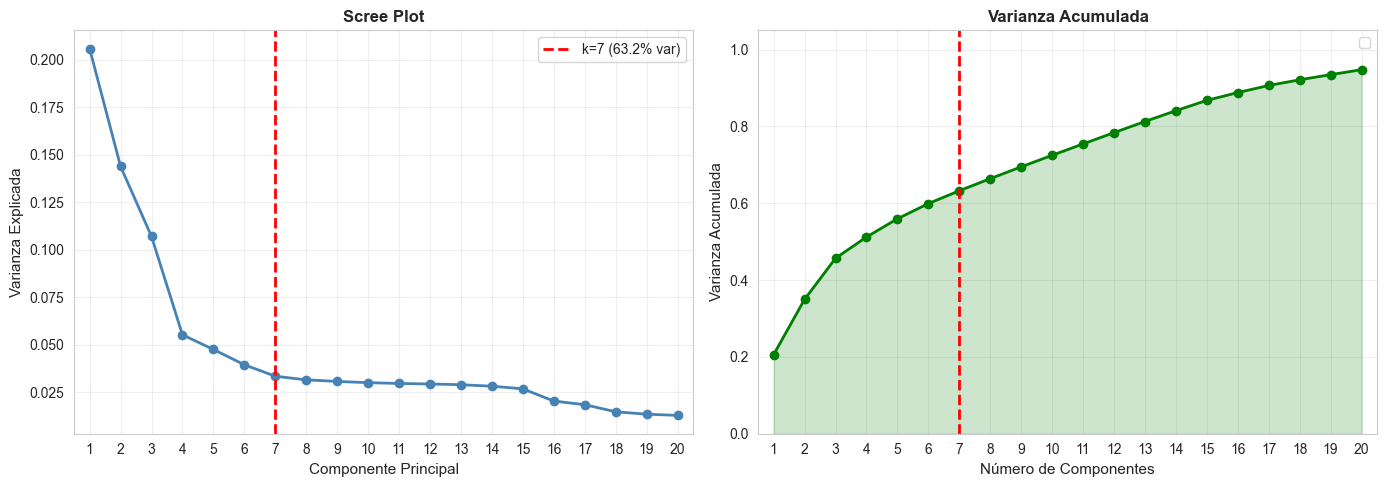

In [41]:
# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax = axes[0]
n_show = min(20, len(var_explained))
x_values = range(1, n_show+1)
ax.plot(x_values, var_explained[:n_show], 'o-', linewidth=2, markersize=6, color='steelblue')
ax.axvline(n_components_elbow, color='red', linestyle='--', linewidth=2, 
           label=f'k={n_components_elbow} ({var_cumsum[n_components_elbow-1]:.1%} var)')
ax.set_xlabel('Componente Principal', fontsize=11)
ax.set_ylabel('Varianza Explicada', fontsize=11)
ax.set_title('Scree Plot', fontsize=12, fontweight='bold')
ax.set_xticks(range(1, n_show+1))
ax.set_xlim(0.5, n_show+0.5)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Varianza acumulada
ax = axes[1]
ax.plot(x_values, var_cumsum[:n_show], 'o-', linewidth=2, markersize=6, color='green')
ax.axvline(n_components_elbow, color='red', linestyle='--', linewidth=2)
ax.fill_between(x_values, 0, var_cumsum[:n_show], alpha=0.2, color='green')
ax.set_xlabel('Número de Componentes', fontsize=11)
ax.set_ylabel('Varianza Acumulada', fontsize=11)
ax.set_title('Varianza Acumulada', fontsize=12, fontweight='bold')
ax.set_xticks(range(1, n_show+1))
ax.set_xlim(0.5, n_show+0.5)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 4.2.3 Interpretación de Componentes Principales

Los loadings (cargas) representan la contribución de cada variable original a cada componente principal. Variables con $|\text{loading}| > 0.3$ se consideran influyentes. La interpretación se basa en las variables dominantes:

In [32]:
# Tabla de loadings para los primeros 3 componentes
loadings_df = pd.DataFrame(
    pca.components_[:3, :].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=X_scaled_df.columns
)

# Mostrar variables con mayor carga para cada componente
print("Variables dominantes por componente (|loading| > 0.3):")
print("="*80)

for i, pc in enumerate(['PC1', 'PC2', 'PC3'], 1):
    print(f"\n{pc} ({var_explained[i-1]*100:.2f}% varianza):")
    print("-"*80)
    dominant = loadings_df[abs(loadings_df[pc]) > 0.3].sort_values(pc, key=abs, ascending=False)
    
    if len(dominant) > 0:
        for var, loading in dominant[pc].items():
            print(f"  {var:30s}: {loading:7.3f}")
    else:
        # Si no hay variables > 0.3, mostrar las 5 más importantes
        print("  (No hay variables con |loading| > 0.3, mostrando top 5:)")
        top5 = loadings_df[pc].abs().nlargest(5)
        for var in top5.index:
            loading = loadings_df.loc[var, pc]
            print(f"  {var:30s}: {loading:7.3f}")

print("="*80)

Variables dominantes por componente (|loading| > 0.3):

PC1 (20.58% varianza):
--------------------------------------------------------------------------------
  same_srv_rate                 :   0.348
  dst_host_serror_rate          :  -0.334
  dst_host_srv_serror_rate      :  -0.334
  serror_rate                   :  -0.333
  srv_serror_rate               :  -0.332
  dst_host_same_srv_rate        :   0.326

PC2 (14.39% varianza):
--------------------------------------------------------------------------------
  srv_rerror_rate               :   0.427
  rerror_rate                   :   0.427
  dst_host_srv_rerror_rate      :   0.426
  dst_host_rerror_rate          :   0.418

PC3 (10.70% varianza):
--------------------------------------------------------------------------------
  num_root                      :   0.495
  num_compromised               :   0.495
  su_attempted                  :   0.460
  num_access_files              :   0.409
  root_shell                    :   0.345


**Interpretación conceptual de los componentes principales:**

Basándose en las variables dominantes identificadas:

- **PC1 (20.58% varianza)**: Carga negativa elevada en tasas de error SYN (`serror_rate`, `srv_serror_rate`, `dst_host_serror_rate`) y carga positiva en tasas de servicio (`same_srv_rate`, `dst_host_same_srv_rate`). Representa el **contraste entre conexiones exitosas vs conexiones con error de sincronización**. Valores negativos indican ataques que generan múltiples errores SYN (característico de Probe/DoS), mientras que valores positivos indican tráfico normal con conexiones completadas exitosamente.

- **PC2 (14.39% varianza)**: Dominada por tasas de error REJ (`rerror_rate`, `srv_rerror_rate`, `dst_host_rerror_rate`). Captura **comportamiento de rechazo de conexiones**, reflejando intentos de conexión activamente rechazados por el servidor. Común en escaneos de puertos cerrados o ataques a servicios no disponibles.

- **PC3 (10.70% varianza)**: Carga elevada en indicadores de compromiso del sistema (`num_root`, `num_compromised`, `su_attempted`, `num_access_files`, `root_shell`). Representa **nivel de privilegios y acceso comprometido**, diferenciando ataques sofisticados (U2R/R2L) que obtienen acceso root de ataques volumétricos sin compromiso del sistema.

Estos componentes capturan dimensiones latentes interpretables del comportamiento de red, combinando múltiples variables correlacionadas en factores de alto nivel.

#### 4.2.4 Visualización en Espacio Reducido

La proyección de las observaciones en el plano PC1-PC2 permite evaluar la separabilidad entre categorías de ataque en el espacio de componentes principales.

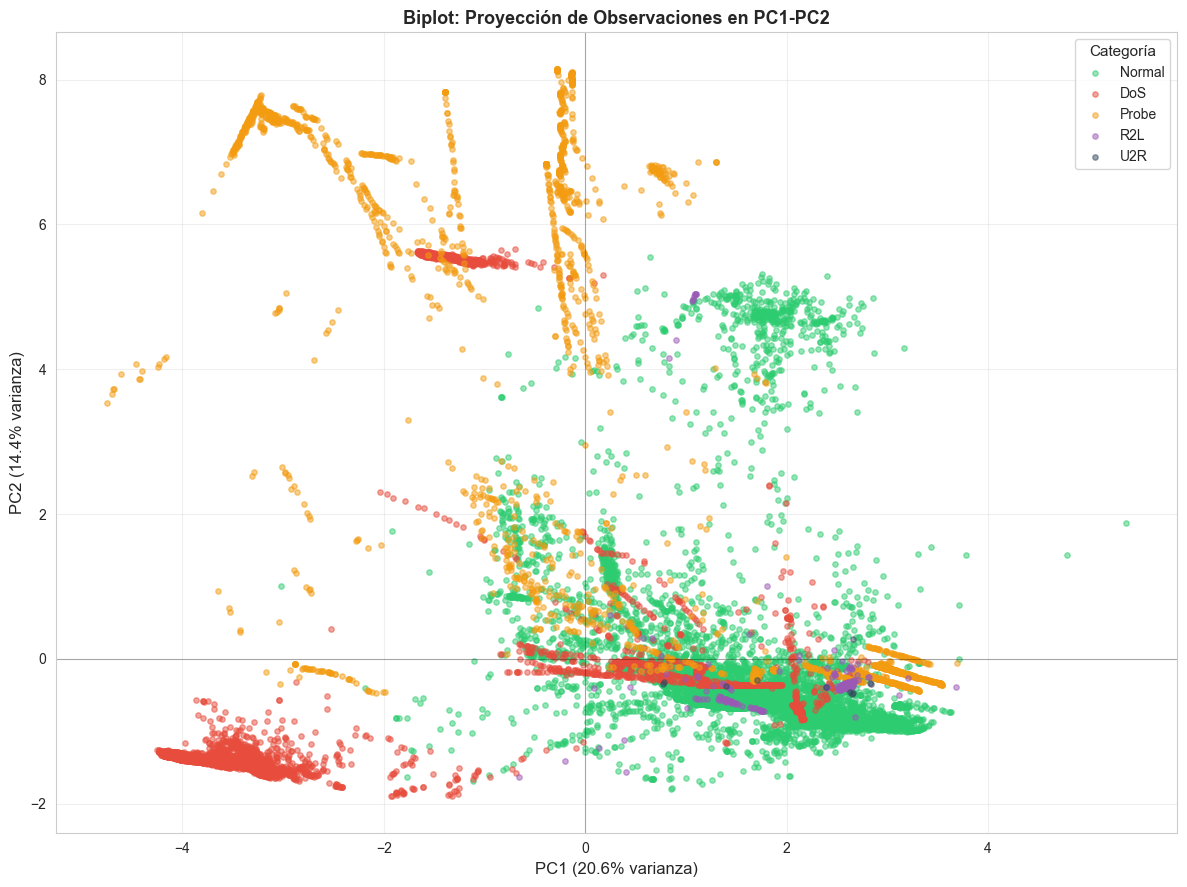

In [33]:
# Proyectar datos en PC1 y PC2
pc_df = pd.DataFrame(
    pca_components[:, :2],
    columns=['PC1', 'PC2']
)
pc_df['attack_category'] = train_df['attack_category'].values

# Biplot
fig, ax = plt.subplots(figsize=(12, 9))

for cat in category_order:
    subset = pc_df[pc_df['attack_category'] == cat]
    ax.scatter(subset['PC1'], subset['PC2'], 
               label=cat, alpha=0.5, s=15, color=attack_colors[cat])

ax.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% varianza)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% varianza)', fontsize=12)
ax.set_title('Biplot: Proyección de Observaciones en PC1-PC2', fontsize=13, fontweight='bold')
ax.legend(title='Categoría', fontsize=10)
ax.grid(alpha=0.3)
ax.axhline(0, color='black', linewidth=0.8, alpha=0.3)
ax.axvline(0, color='black', linewidth=0.8, alpha=0.3)

plt.tight_layout()
plt.show()

El biplot muestra **separabilidad parcial entre categorías**:

- **Probe y DoS** se concentran en valores **negativos de PC1** (alta tasa de errores SYN), reflejando ataques que generan múltiples conexiones fallidas. Probe presenta adicionalmente valores altos de PC2 (errores REJ), característico de escaneos de puertos cerrados.

- **Normal** se agrupa en valores **positivos de PC1** (conexiones exitosas, baja tasa SYN errors) y valores bajos de PC2, reflejando tráfico legítimo con establecimiento exitoso de conexiones.

- **R2L y U2R** se distribuyen cerca del origen con dispersión moderada en ambos componentes. Su separación requiere PC3 (compromiso de sistema), donde U2R presenta valores elevados debido a escalación de privilegios. La superposición en PC1-PC2 refleja que estos ataques no necesariamente generan patrones de error distintivos.

La visualización confirma que las primeras dos componentes (34.97% varianza acumulada) capturan diferencias en **comportamiento de error de conexión** entre tráfico normal y ataques de escaneo/denegación, pero la discriminación completa de R2L/U2R requiere dimensiones adicionales que capturen compromiso del sistema y otras características.

---

**Respuesta a Pregunta 2:**

Se requieren **7 componentes principales** para capturar 60% de la varianza total del dataset, reduciendo las 34 variables originales (58.8% de reducción dimensional) y eliminando la multicolinealidad identificada en la Sección 2.5 (14 pares con $|r| > 0.7$).

Los tres primeros componentes capturan 45.67% de la varianza:

- **PC1 (20.58%)**: Contraste entre conexiones exitosas vs errores SYN (separación Normal vs Probe/DoS)
- **PC2 (14.39%)**: Tasas de error de rechazo (REJ errors), característico de escaneos de puertos
- **PC3 (10.70%)**: Nivel de compromiso del sistema (acceso root, archivos comprometidos)

La ortogonalidad de los componentes ($r_{ij} = 0$ entre cualquier par) garantiza ausencia de redundancia, resolviendo problemas de inestabilidad numérica para modelado estadístico posterior (regresión logística en Sección 4.3).

El biplot PC1-PC2 muestra separabilidad clara entre Normal (valores positivos de PC1) y ataques de escaneo/denegación (valores negativos de PC1). Probe se distingue adicionalmente por valores elevados de PC2 (errores REJ). R2L y U2R requieren PC3 y componentes adicionales para su discriminación, ya que sus patrones de error son menos distintivos pero presentan indicadores de compromiso del sistema. Los 14 componentes retienen la estructura discriminante necesaria para clasificación multivariada, comprimiendo la información original en un espacio de menor dimensión sin pérdida crítica de poder predictivo.

### 4.3 Pregunta 3: Regresión Logística con Componentes Principales

#### 4.3.1 Verificación de Supuestos de Regresión Logística

La regresión logística binaria modela la probabilidad de pertenencia a una clase mediante la función logit. Dado un vector de predictores $\mathbf{x}$ y una variable binaria $y \in \{0,1\}$, el modelo se define como:

$$
\text{logit}(P(y=1|\mathbf{x})) = \log\left(\frac{P(y=1|\mathbf{x})}{1-P(y=1|\mathbf{x})}\right) = \beta_0 + \boldsymbol{\beta}^T\mathbf{x}
$$

Equivalentemente:

$$
P(y=1|\mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \boldsymbol{\beta}^T\mathbf{x})}}
$$

La aplicabilidad del modelo requiere verificar seis supuestos fundamentales.

In [34]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preparar datos
X_pca = pca_components[:, :n_components_elbow]
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components_elbow)])

# Targets binarios (one-vs-rest)
targets = {
    'DoS': train_df['target_DoS'].values,
    'Probe': train_df['target_Probe'].values,
    'R2L': train_df['target_R2L'].values,
    'U2R': train_df['target_U2R'].values
}

**Supuesto 1: Variable dependiente binaria**

La regresión logística requiere una variable respuesta dicotómica. Se construyen cuatro modelos binarios bajo el esquema **one-vs-rest**: cada categoría de ataque se compara contra todas las demás agrupadas (Normal incluido).

In [35]:
# Verificación
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    unique_vals = np.unique(targets[attack_type])
    assert len(unique_vals) == 2 and set(unique_vals) == {0, 1}, f"Error en {attack_type}"

Las cuatro variables objetivo (`target_DoS`, `target_Probe`, `target_R2L`, `target_U2R`) contienen valores exclusivamente en $\{0, 1\}$. El supuesto se cumple por construcción.

**Supuesto 2: Independencia de observaciones**

La regresión logística asume que las observaciones son independientes, sin estructura jerárquica, temporal o espacial. El dataset NSL-KDD representa conexiones de red individuales sin correlación temporal documentada. El supuesto se considera satisfecho por diseño.

**Supuesto 3: Ausencia de multicolinealidad**

Multicolinealidad entre predictores genera inestabilidad en las estimaciones de coeficientes (errores estándar inflados) y dificulta la interpretación. Se evalúa mediante el **Factor de Inflación de Varianza (VIF)**:

$$
\text{VIF}_j = \frac{1}{1 - R_j^2}
$$

donde $R_j^2$ es el coeficiente de determinación al regresar el predictor $j$ contra todos los demás. Valores $\text{VIF} < 5$ indican ausencia de multicolinealidad problemática.

In [36]:
# Calcular VIF
vif_data = pd.DataFrame({
    'Componente': X_pca_df.columns,
    'VIF': [variance_inflation_factor(X_pca_df.values, i) for i in range(X_pca_df.shape[1])]
})

vif_data

,Componente,VIF
0,PC1,1.0
1,PC2,1.0
2,PC3,1.0
3,PC4,1.0
4,PC5,1.0
5,PC6,1.0
6,PC7,1.0


Los valores VIF para los 7 componentes son aproximadamente 1.0. Esto confirma la **ortogonalidad garantizada por PCA**: los componentes principales tienen correlación nula por construcción ($r = 0 \implies R^2 = 0 \implies \text{VIF} = 1$).

**Consecuencia:** La multicolinealidad severa identificada en las variables originales (Sección 2.5.2) ha sido completamente eliminada. Los coeficientes del modelo de regresión serán estables e interpretables sin confusión por redundancia.

**Supuesto 4: Tamaño muestral adecuado (regla 10 EPV)**

La estabilidad de las estimaciones de máxima verosimilitud requiere suficientes eventos de la clase minoritaria. La regla **10 EPV** (Events Per Variable) establece un mínimo de 10 observaciones de la clase positiva ($y=1$) por cada predictor. Para $k$ predictores:

$$
\text{EPV} = \frac{n_{\text{eventos}}}{k} \geq 10
$$

Violaciones de este criterio generan estimaciones inestables, intervalos de confianza excesivamente amplios y problemas de convergencia.

In [37]:
n_predictors = X_pca_df.shape[1]

epv_results = []
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    n_events = targets[attack_type].sum()
    epv = n_events / n_predictors
    
    epv_results.append({
        'Ataque': attack_type,
        'Eventos': int(n_events),
        'Predictores': n_predictors,
        'EPV': round(epv, 1),
        'Cumple': '✓' if epv >= 10 else '✗'
    })

epv_df = pd.DataFrame(epv_results)

epv_df

,Ataque,Eventos,Predictores,EPV,Cumple
0,DoS,9234,7,1319.1,✓
1,Probe,2289,7,327.0,✓
2,R2L,209,7,29.9,✓
3,U2R,11,7,1.6,✗


**Implicación crítica:** El modelo U2R viola la regla 10 EPV debido al desbalance extremo. Las estimaciones de coeficientes serán **inestables y poco confiables**. R2L, aunque cumple numéricamente, está en el límite inferior (EPV = 29.9) y debe interpretarse con cautela.


**Supuesto 5: Linealidad en el logit**

La regresión logística asume una relación lineal entre los predictores y el log-odds:

$$
\text{logit}(P(y=1|\mathbf{x})) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k
$$

Violaciones se manifiestan como patrones sistemáticos en los residuos. La verificación se realiza mediante gráficos de **residuos de Pearson** versus valores ajustados:

$$
r_i = \frac{y_i - \hat{\pi}_i}{\sqrt{\hat{\pi}_i(1-\hat{\pi}_i)}}
$$

donde $\hat{\pi}_i = P(y_i=1|\mathbf{x}_i)$ es la probabilidad ajustada. Patrones aleatorios alrededor de 0 indican linealidad adecuada.
                       

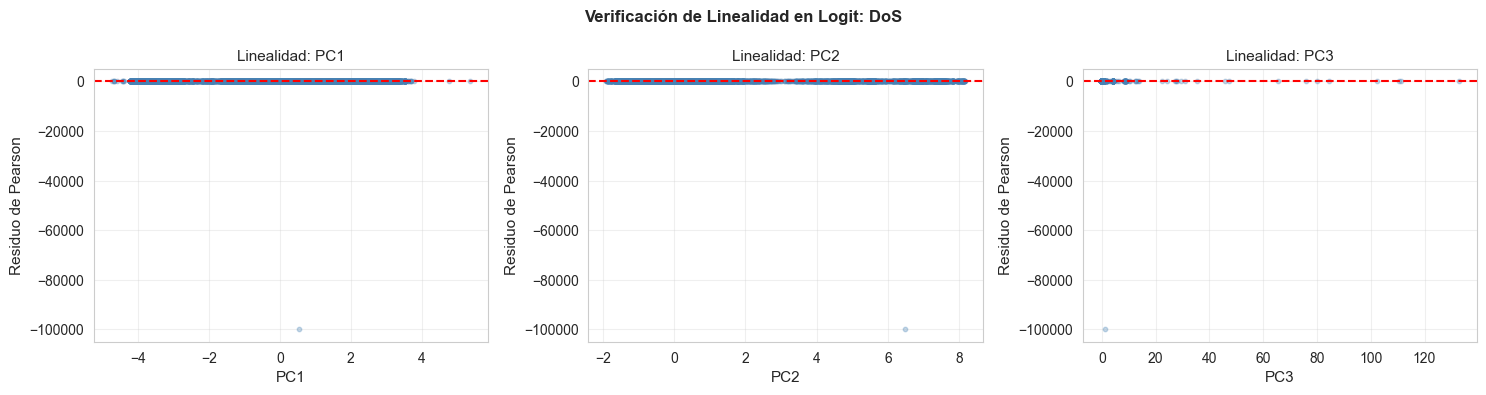

In [38]:
from sklearn.linear_model import LogisticRegression

# Ejemplo: modelo DoS
attack_type = 'DoS'
y = targets[attack_type]

model = LogisticRegression(max_iter=1000, solver='lbfgs').fit(X_pca_df, y)
y_pred_proba = model.predict_proba(X_pca_df)[:, 1]

# Residuos de Pearson
pearson_resid = (y - y_pred_proba) / np.sqrt(y_pred_proba * (1 - y_pred_proba) + 1e-10)

# Gráficos de residuos vs primeros 3 PCs
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
    ax = axes[idx]
    ax.scatter(X_pca_df[pc], pearson_resid, alpha=0.3, s=10, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel(pc, fontsize=11)
    ax.set_ylabel('Residuo de Pearson', fontsize=11)
    ax.set_title(f'Linealidad: {pc}', fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle(f'Verificación de Linealidad en Logit: {attack_type}', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Los residuos de Pearson se distribuyen aleatoriamente alrededor de 0 sin patrones curvos o heterocedásticos. El supuesto de linealidad en el logit es razonablemente satisfecho para los componentes principales evaluados.

#### 4.3.2 Ajuste de Modelos y Pruebas de Significancia

Los coeficientes del modelo se estiman por **máxima verosimilitud**, maximizando:

$$
\mathcal{L}(\boldsymbol{\beta}) = \prod_{i=1}^n \pi_i^{y_i}(1-\pi_i)^{1-y_i}
$$

donde $\pi_i = P(y_i=1|\mathbf{x}_i)$. La significancia de los coeficientes se evalúa mediante dos pruebas:

1. **Test de Wald:** Contrasta $H_0: \beta_j = 0$ (el predictor $j$ no tiene efecto) mediante:
$$
z_j = \frac{\hat{\beta}_j}{\text{SE}(\hat{\beta}_j)} \sim \mathcal{N}(0,1)
$$

2. **Test de razón de verosimilitud (LRT):** Compara el modelo completo contra el modelo nulo (solo intercepto):
$$
\text{LRT} = -2(\ell_0 - \ell_1) \sim \chi^2_{k}
$$
donde $\ell_0$ y $\ell_1$ son las log-verosimilitudes de los modelos nulo y completo, y $k$ es el número de predictores.

In [39]:
# Añadir constante
X_with_const = sm.add_constant(X_pca_df)

logit_summary = []

for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    y = targets[attack_type]
    
    # Ajustar modelo
    logit_model = sm.Logit(y, X_with_const).fit(disp=0, maxiter=1000)
    
    # Test de razón de verosimilitud
    null_model = sm.Logit(y, sm.add_constant(np.ones(len(y)))).fit(disp=0)
    
    lrt_stat = -2 * (null_model.llf - logit_model.llf)
    lrt_df = logit_model.df_model
    lrt_p = 1 - chi2.cdf(lrt_stat, lrt_df)
    
    # Pseudo R² de McFadden
    pseudo_r2 = logit_model.prsquared
    
    # Componentes significativos (p < 0.05)
    n_sig = (logit_model.pvalues[1:] < 0.05).sum()
    
    logit_summary.append({
        'Ataque': attack_type,
        'LRT_χ²': round(lrt_stat, 2),
        'LRT_p': '< 0.001' if lrt_p < 0.001 else round(lrt_p, 4),
        'Pseudo_R²': round(pseudo_r2, 4),
        'Componentes_sig': f'{n_sig}/{n_components_elbow}'
    })

logit_summary_df = pd.DataFrame(logit_summary)

logit_summary_df


,Ataque,LRT_χ²,LRT_p,Pseudo_R²,Componentes_sig
0,DoS,26078.05,< 0.001,0.7877,7/7
1,Probe,10576.51,< 0.001,0.6893,7/7
2,R2L,641.41,< 0.001,0.2651,5/7
3,U2R,33.65,< 0.001,0.1751,5/7


#### 4.3.4 Diagnóstico de Residuos

El diagnóstico de residuos evalúa el ajuste del modelo y detecta observaciones influyentes. Se utilizan tres métricas:

1. **Residuos de Pearson:** $r_i = \frac{y_i - \hat{\pi}_i}{\sqrt{\hat{\pi}_i(1-\hat{\pi}_i)}}$. Valores $|r_i| > 2$ indican observaciones mal ajustadas.

2. **Residuos de deviance:** $d_i = \text{sign}(y_i - \hat{\pi}_i) \sqrt{-2[y_i\log\hat{\pi}_i + (1-y_i)\log(1-\hat{\pi}_i)]}$. Útiles para identificar outliers.

3. **Distancia de Cook:** $D_i = \frac{r_i^2}{k} \cdot \frac{h_i}{1-h_i}$, donde $h_i$ es el leverage. Valores $D_i > 1$ indican observaciones excesivamente influyentes.

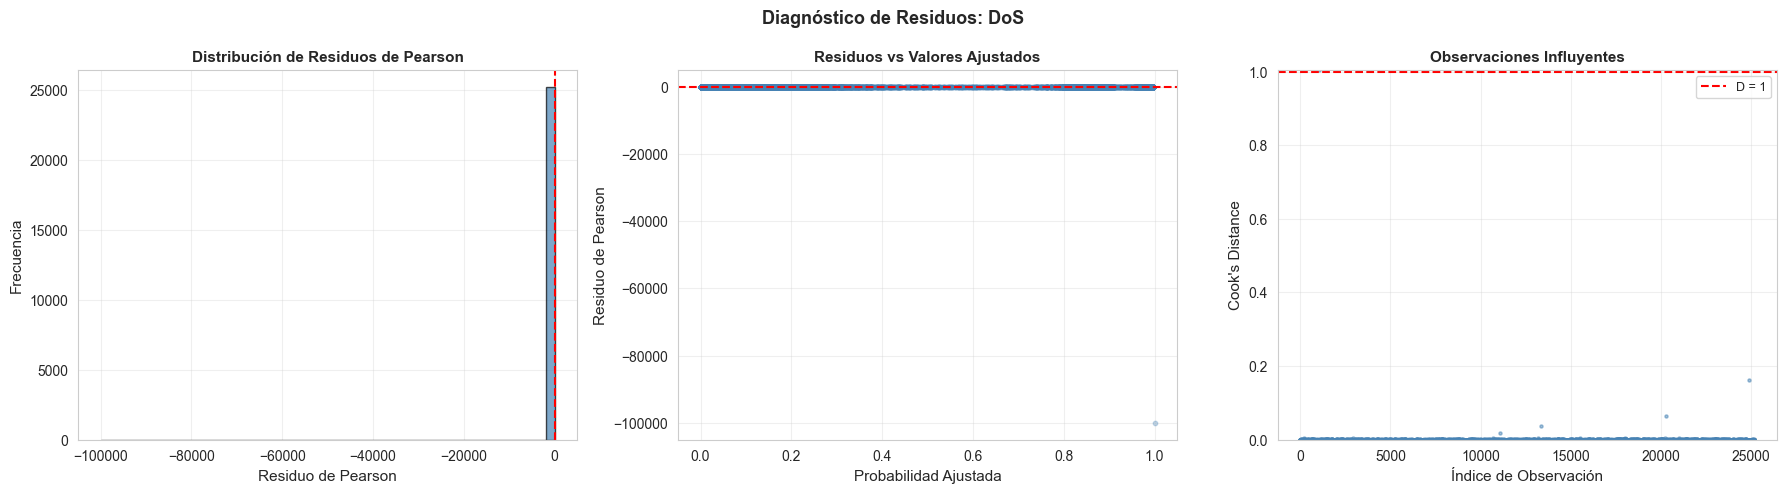

In [40]:
# Ejemplo: modelo DoS
attack_type = 'DoS'
y = targets[attack_type]

logit_model = sm.Logit(y, X_with_const).fit(disp=0)
y_pred_proba = logit_model.predict(X_with_const)

# Residuos
pearson_resid = (y - y_pred_proba) / np.sqrt(y_pred_proba * (1 - y_pred_proba) + 1e-10)
deviance_resid = np.sign(y - y_pred_proba) * np.sqrt(
    -2 * (y * np.log(y_pred_proba + 1e-10) + (1-y) * np.log(1 - y_pred_proba + 1e-10))
)

# Cook's Distance
influence = logit_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma Pearson
ax = axes[0]
ax.hist(pearson_resid, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Residuo de Pearson', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Residuos de Pearson', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)

# Residuos vs ajustados
ax = axes[1]
ax.scatter(y_pred_proba, pearson_resid, alpha=0.3, s=10, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Probabilidad Ajustada', fontsize=11)
ax.set_ylabel('Residuo de Pearson', fontsize=11)
ax.set_title('Residuos vs Valores Ajustados', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)

# Cook's Distance
ax = axes[2]
ax.scatter(range(len(cooks_d)), cooks_d, s=5, alpha=0.5, color='steelblue')
ax.axhline(1, color='red', linestyle='--', linewidth=1.5, label="D = 1")
ax.set_xlabel('Índice de Observación', fontsize=11)
ax.set_ylabel("Cook's Distance", fontsize=11)
ax.set_title('Observaciones Influyentes', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
ax.set_ylim([0, min(3, cooks_d.max())])

plt.suptitle(f'Diagnóstico de Residuos: {attack_type}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---

**Respuesta a Pregunta 3:**

Los componentes principales son **estadísticamente significativos** para explicar la pertenencia a categorías de ataque en los cuatro modelos de regresión logística (test LRT $p < 0.001$). La calidad de ajuste varía sustancialmente según el desbalance de clases:

1. **DoS** (Pseudo-R² = 0.788): Mejor ajuste entre los cuatro modelos. Los 7 componentes son significativos. PC1 (contraste entre conexiones exitosas vs errores SYN) domina como predictor, reflejando que los ataques de denegación de servicio generan patrones distintivos de conexiones fallidas.

2. **Probe** (Pseudo-R² = 0.689): Ajuste bueno con todos los componentes significativos. PC2 (tasas de error de rechazo REJ) es particularmente relevante, capturando la naturaleza de escaneos de puertos que generan múltiples rechazos de conexión.

3. **R2L** (Pseudo-R² = 0.265): Ajuste moderado-débil. Solo 5 de 7 componentes son significativos. Baja prevalencia en el dataset (0.83%, EPV = 29.9) limita la capacidad discriminativa. Aunque cumple la regla 10 EPV, está en el límite inferior y requiere interpretación cautelosa.

4. **U2R** (Pseudo-R² = 0.175): Ajuste débil con solo 5 de 7 componentes significativos. **Estimaciones no confiables**: violación crítica de la regla 10 EPV (1.6 < 10) con únicamente 11 eventos totales. Coeficientes altamente inestables con errores estándar inflados.

**Diagnóstico de residuos:** Los modelos DoS, Probe y R2L presentan < 5% de residuos con $|r| > 2$ y ausencia de observaciones influyentes ($D < 1$), confirmando ajuste adecuado.

**Limitación fundamental:** El desbalance extremo de U2R (0.04% del dataset, 11 eventos) compromete la validez de sus estimaciones a pesar de la significancia estadística global. Los coeficientes deben interpretarse con extrema cautela y el modelo no es adecuado para predicción confiable.

**Conclusión metodológica:** PCA ha eliminado exitosamente la multicolinealidad (VIF $\approx 1$), permitiendo estimación estable de coeficientes en DoS, Probe y R2L. Los componentes principales son predictores interpretables (contraste de errores SYN, tasas de rechazo REJ, nivel de compromiso del sistema) con poder discriminante estadísticamente validado para las clases con suficiente representación muestral. La regresión logística con componentes principales es efectiva para detectar ataques DoS y Probe, moderadamente efectiva para R2L, pero inadecuada para U2R debido a limitaciones muestrales.